# Приветствие
Доброго времени суток!
Меня зовут Голубев Артём Алексеевич.
Ниже представлена работа по домашнему заданию 2.
Приятного времяпровождения! :)


# Задание
## ВАМ НЕОБХОДИМО:
1.	Ознакомьтесь с содержанием демонстрационных блокнотов,
2.	Создайте новый блокнот, импортируйте необходимые библиотеки (не обязательно копировать все - только нужные функции и /или классы),
3.	Выполните следующие задания (Каждое задание в под отдельным заголовком #).
## 1.  Для синтетических данных:
1.	Сгенерируйте различные линейные, полиномиальные и другие зависимости отличные от тех, что в примере(как минимум 3 поднабора).
2.	Проверьте как с этими наборами справятся полиномы различной степени и разные типы регуляризации (для каждого набора проверьте как минимум по 2 модели).
3.	Для удобства можете создать новые функции. 
## 2.  Для набора данных Cars Moldova:
1.	Скачайте набор данных Cars Moldova (сразу очищенных от дубликатов и выбросов, лучше с добавленными признаками из «Задания 1»).
2.	 Используйте любую из подготовленных вами моделей линейной регрессии для предсказания цены автомобилей на вторичном рынке Молдавии. Оцените модель на отложенной выборке.
3.	Оцените влияние разных типов предварительной обработки на результат (использование стандартизации, нормализации или степенного преобразования для числовых признаков).
4.	Сравните результаты модели при использовании только числовых признаков и при добавлении категориальных признаков с помощью one-hot кодирования.
5.	Оцените наиболее значимые признаки для модели проанализировав веса.


# Перейдём к выполнению задания

## Импорты, функции и классы

### Импорты:

In [304]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns; 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

Далее копирую функции и классы. Делаю это всем скопом, чтобы не поломать зависимости (и немножко сэкономить себе время на разборки с кодом):

### Функции

In [305]:
def true_fun(x, a=np.pi, b = 0, f=np.sin):
    x = np.atleast_1d(x)[:]
    a = np.atleast_1d(a)
    
    if f is None: f = lambda x:x # line
    x = np.sum([ai*np.power(x, i+1) for i,ai in enumerate(a)],axis=0)

    return f(x+ b)

def noises(shape , noise_power):
    return np.random.randn(*shape) *noise_power

def dataset(a, b, f = None,  N = 250, x_max =1, noise_power = 0, random_x = True,  seed = 42):
    np.random.seed(seed)
    
    if random_x:
        x = np.sort(np.random.rand(N))*x_max    
    else:
        x = np.linspace(0,x_max,N)
    
    y_true = np.array([])
    
    for f_ in np.append([], f):
        y_true=np.append(y_true, true_fun(x, a, b, f_))
    
    y_true = y_true.reshape(-1,N).T
    y = y_true + noises(y_true.shape , noise_power)

    return y, y_true, np.atleast_2d(x).T

In [306]:
def vis_data(y, y_true,x, title):
    fig  = plt.figure(figsize=(15,10))
    plt.scatter(x[:,0], y, edgecolor='b', label="Зашумленные Данные",s=196, alpha = 0.6)
    plt.scatter(x[:,0], y_true,label="Реальные Данные", s=81,c='g', alpha = 0.8)
    plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35)
    plt.legend(fontsize=25)
    plt.title(title, fontsize=25 )
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    plt.tight_layout()


In [307]:
def train_test_split(x,y, train_size=None, test_size=None, random_state=42, shuffle=True,):
    if random_state: np.random.seed(random_state)
    
    size = y.shape[0]
    idxs = np.arange(size)
    if shuffle: np.random.shuffle(idxs)
    
    if test_size and train_size is None:
        if (test_size<= 1):  train_size = 1 - test_size
        else:  train_size = size - test_size
        test_size = None    
        
    if train_size is None or train_size > size: train_size = size
        
    if (train_size<= 1): train_size *= size
        
    if test_size is not None: 
        if test_size<= 1: test_size *= size    
        if test_size>size: test_size = size-train_size
    else: test_size = 0

    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    x_val,   y_val   = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]
    
    if test_size > 0:
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        return x_train,  x_val, x_test, y_train.squeeze(), y_val.squeeze(), y_test.squeeze() 
    return x_train, x_val, y_train.squeeze(), y_val.squeeze()


In [308]:
def init_weights(W_shape, add_bias = True, random_state = 42):
    W_shape = np.atleast_1d(W_shape)
    if random_state: 
        np.random.seed(random_state)
    W = np.random.randn(*list(W_shape))/np.sqrt(np.sum(W_shape))    
    if add_bias: 
        W = np.column_stack((np.zeros(W.shape[-1]),W ))
    return W.squeeze()

In [309]:
def predict( X, W, add_bias = True):
    if add_bias:
        X_full = np.column_stack((np.ones(X.shape[0]),X))
    else:
        X_full = X
    return  np.dot(X_full,W)

def loss_func(yhat, y):
    return np.square(yhat - y)  

In [310]:
def grad_loss(y_hat, y, X, add_bias = True):
    if add_bias:
        X_full = np.column_stack((np.ones(X.shape[0]),X))
    else:
        X_full = X
    return 2*np.dot(X_full.T, (y_hat - y)) / y.size  

In [311]:
def update_weights(grad, W, learning_rate):
    return W - learning_rate*grad

In [312]:
def fit(X, y, learning_rate, weights = None,  epochs=30):

    if weights is None: weights = init_weights(X.shape[1])
    cost    = np.zeros(epochs)

    for i in range(epochs): 
        yhat    = predict(X,weights)
        grad    = grad_loss(yhat,  y, X) 
        weights = update_weights(grad, weights, lerning_rate)  
        cost[i] = loss_func(yhat,  y).mean()
                
    return weights, cost

In [313]:
def plot_cost(cost):
    plt.plot(cost, 'o-', linewidth = 4, markersize = 15); 
    plt.grid()
    plt.xlabel("Эпоха",fontsize=35)
    plt.ylabel("Функция Потерь",fontsize=35)
    plt.xticks(fontsize = 25)

    plt.yticks(fontsize = 25);  

In [314]:
def r2_score(yhat, y):    
    return 1-(np.square(y-yhat)).sum(axis=0)/(np.square(y-np.mean(y, axis=0))).sum(axis=0)

In [315]:
def plot_model_weights(x_train, y_train, x_test, x, y, weights):
    plt.plot(x_train[:,0], predict(x_train,weights, ),
            '.', label='Предсказание на x_train',
            markersize = 15)
    plt.plot(x_test[:,0], predict(x_test,weights, ),
            'o', label='Предсказание на x_test',
            markersize = 15, alpha =0.8)
    plt.plot(x_train[:,0], y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label="Истинные Значения", linewidth=4,c='g')
    plt.legend(fontsize=20); plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35)
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)

In [316]:
def vis_weigths(weights, names):
    numbers = np.arange(0,len(weights))
    tick_labels = names
    cc=['']*len(numbers)
    for n,val in enumerate(weights):
        if val<0:
            cc[n]='red'
        elif val>=0:
            cc[n]='blue'

    plt.bar(x = numbers, height = weights, color = cc)
    plt.xticks(np.arange(0,len(weights)),tick_labels, rotation = 90 )

In [317]:
def load_batch(X,y, batch_size = 100):
    idxs = np.arange(y.size)
    np.random.shuffle(idxs)

    for i_batch in range(0,y.size,batch_size):
        idx_batch = idxs[i_batch:i_batch+batch_size]
        x_batch   = np.take(X, idx_batch,axis=0)
        y_batch   = np.take(y, idx_batch)
        yield  x_batch, y_batch

In [318]:
def fit_SGD(X, y, lerning_rate, weights = None,  epochs=30, batch_size = 100, random_state = 42):
    
    if random_state: np.random.seed(random_state)

    if weights is None: weights = init_weights(X.shape[1])
    if batch_size is None or batch_size>y.size : batch_size = y.size
    n_batches = y.size//batch_size
    
    cost    = np.zeros(epochs)

    for i in range(epochs): 
        loss = 0
        for cnt,(x_batch, y_batch) in enumerate(load_batch(X,y, batch_size)): 

            yhat    = predict(x_batch, weights)
            grad    = grad_loss(yhat,  y_batch, x_batch) 
            weights = update_weights(grad, weights, lerning_rate) #backward 
            loss   += loss_func(yhat,  y_batch).mean()

            if cnt>= n_batches:
                break
        cost[i] = loss/n_batches

    return weights, cost

In [319]:
def plot_model_class(x_train, y_train, x_test, x, y, model):
    plt.plot(x_train[:,0], model.predict(x_train),
            '.', label='Предсказание на x_train',
            markersize = 15)
    plt.plot(x_test[:,0], model.predict(x_test),
            'o', label='Предсказание на x_test',
            markersize = 15, alpha =0.8)
    plt.plot(x_train[:,0], y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label="Истинные Значения", linewidth=4,c='g')
    plt.legend(fontsize=20); plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35)
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)

In [320]:
def to_polynom(x, order = 1, add_bias = False):
    order_range = range( 0 if add_bias else 1, order+1,1)
    x = np.atleast_1d(x)[:]    
    out = np.array([])
    for i in order_range:
        out = np.append(out, np.power(x,i))
    return out.reshape(-1, x.size).T



In [321]:
def polyval(x,weights):
    return np.sum([np.power(x,i)*wi for i, wi in enumerate(weights) ],axis = 0) # including bias!

### Классы:

In [322]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return np.dot(X, self.weights)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

In [323]:
class MinMaxScaler:
    def __init__(self):
        self.min = 0
        self.max = 0
    def fit(self,X):
        self.min = X.min(axis = 0)
        self.max = X.max(axis = 0)
        return self
    def transform(self,X):
        return (X- self.min)/(self.max-self.min)
    def fit_transform(self,X):
        return self.fit(X).transform(X)

In [324]:
class StandardScaler:
    def __init__(self):
        self.mean = 0
        self.std = 1
    def fit(self,X):
        self.mean = X.mean(axis = 0)
        self.std = X.std(axis = 0)
        return self
    def transform(self,X):
        return (X- self.mean)/(self.std)
    def fit_transform(self,X):
        return self.fit(X).transform(X)

In [325]:
class RidgeRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l2_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l2_term

    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.mean(self.weights[1:])
        return self.weights - self.lr*(self.grad + l2_term)  


In [326]:
class LassoRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
    
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term
                  
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*(self.grad + np.sign(self.weights)*self.l1_penalty)

In [327]:
class ElasticRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term + l2_term
                  
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad +  np.sign(self.weights)*self.l1_penalty + l2_term)

## 1. Синтетические данные.

Сгенерируйте различные линейные, полиномиальные и другие зависимости отличные от тех, что в примере(как минимум 3 поднабора).

### 1.1. Линейная зависимость.

Сначала сгенерируем линейную зависимость:

<Figure size 1600x900 with 0 Axes>

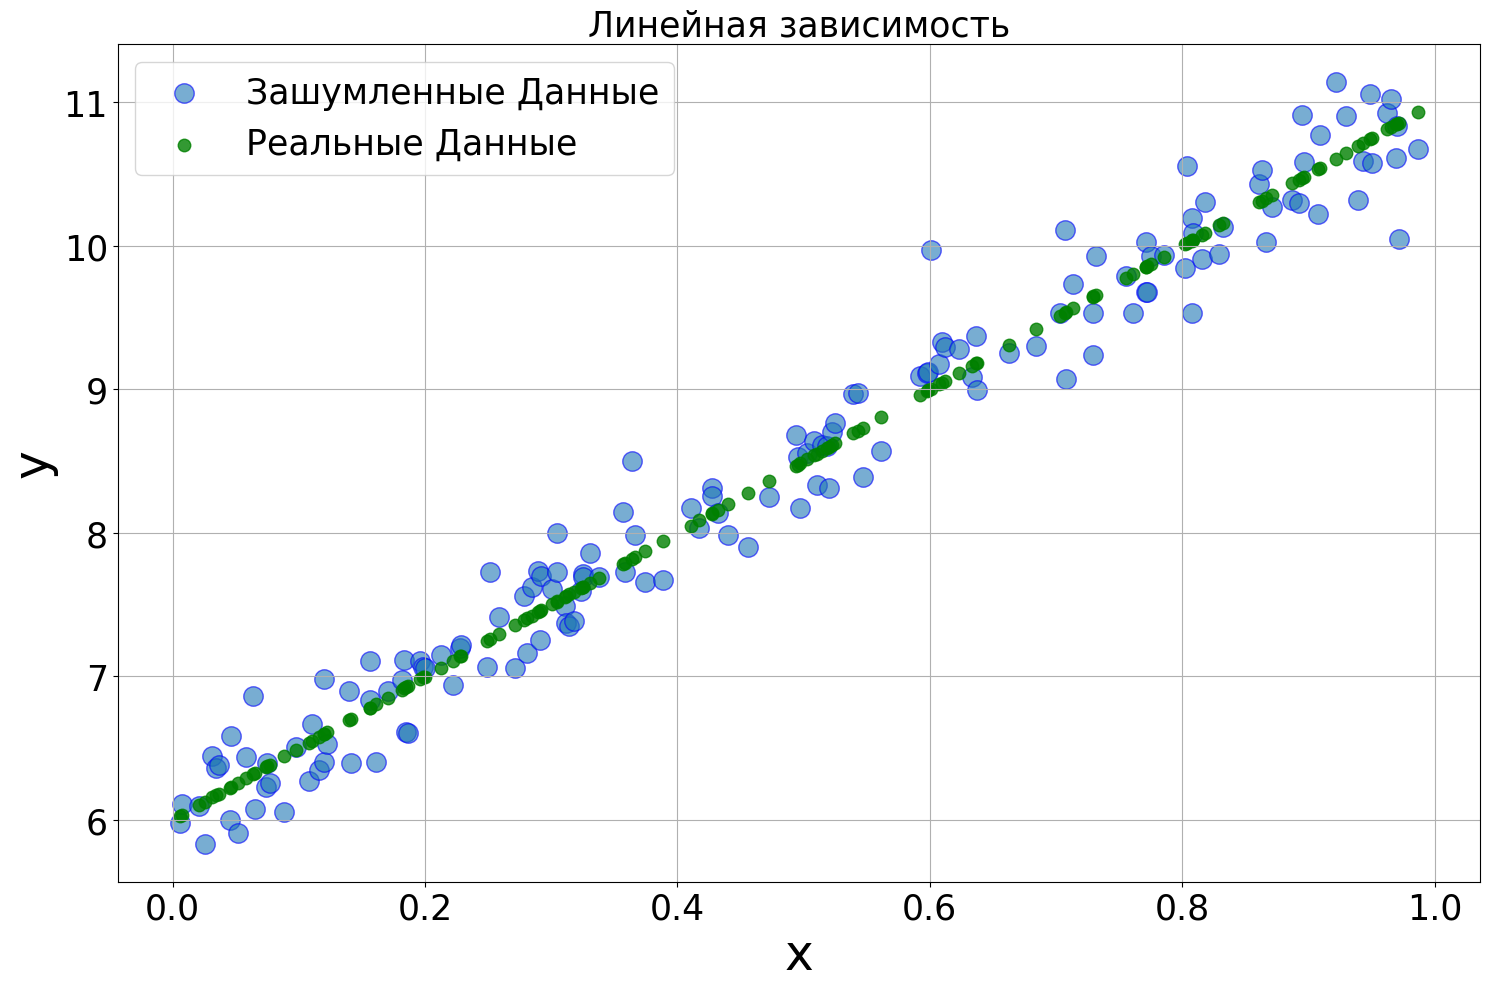

In [328]:
noise_power = 0.25

fig  = plt.figure(figsize=(16,9))
y, y_true, x = dataset(a = 5, b = 6,
                       f = None,  N = 150,
                       x_max = 1, 
                       noise_power = noise_power,
                       seed = 42)
vis_data(y, y_true,x, 'Линейная зависимость')

Посчитаем линейную регрессию с заданными параметрами:

In [329]:
regr_linear = LinearRegression(learning_rate=0.1,
                        epochs=10,batch_size=10,
                        n_batches=None)

Теперь обучим модель на тренировочных данных, применим вычисления и выведем результаты на график:

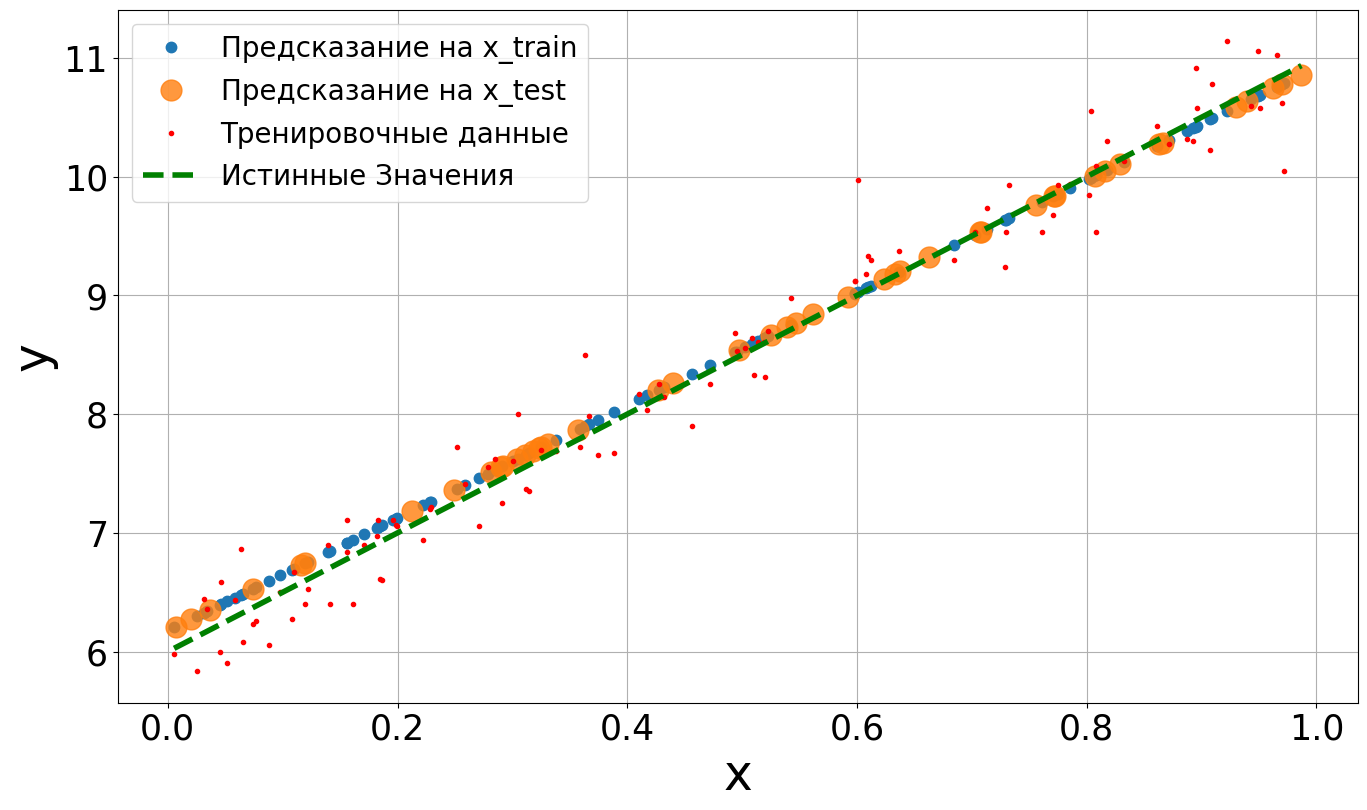

In [330]:
x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.3)
regr_linear.fit(x_train, y_train)

fig  = plt.figure(figsize=(16,9))
plot_model_class(x_train, y_train, x_test, x, y_true, regr_linear)

Проверим полином четвертой степени для этой регрессии. В целом справляется относительно неплохо, но от истинных значений уже далековато... :

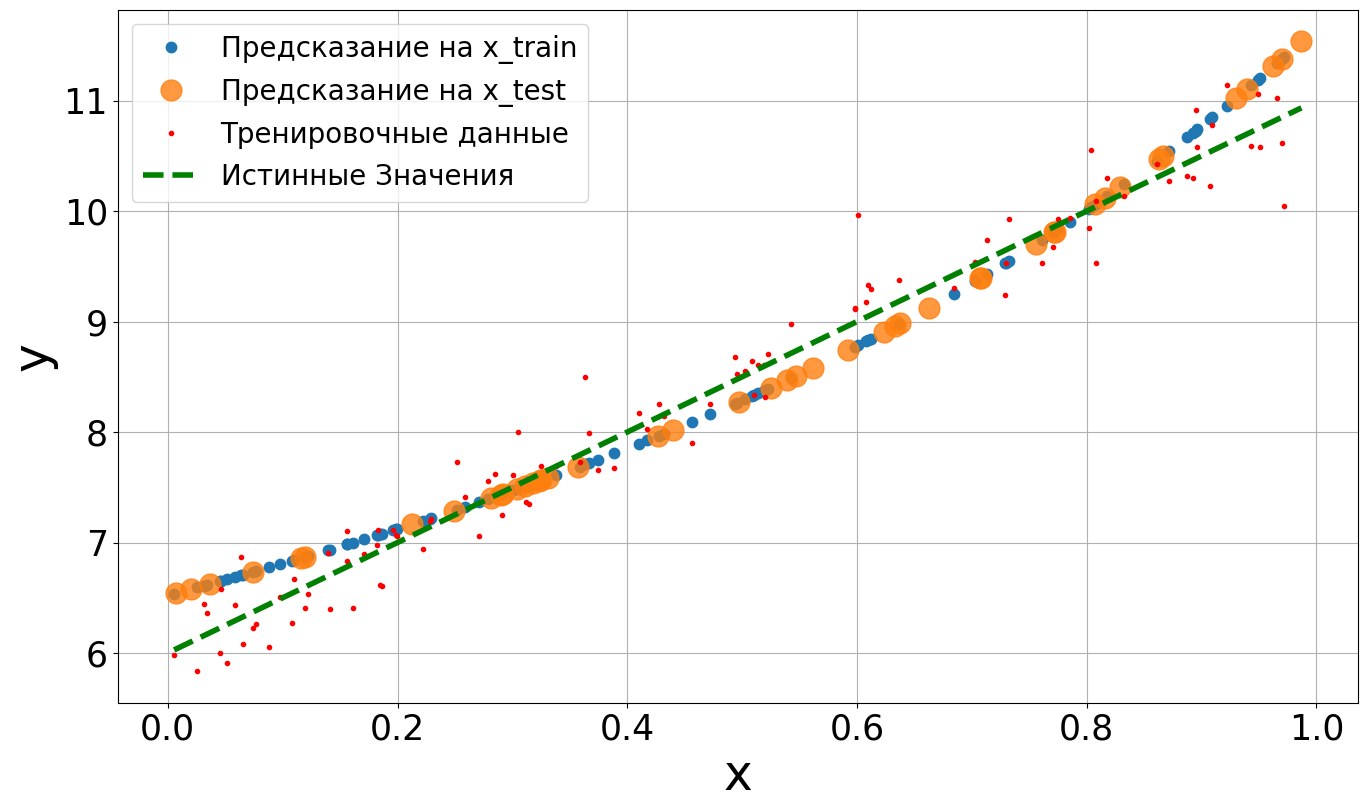

In [331]:
y, y_true, x = dataset(a = 5, b = 6,
                       f = None,  N = 150,
                       x_max = 1, 
                       noise_power = noise_power,
                       seed = 42)
x = to_polynom(x, order = 4)

regr_linear = LinearRegression(learning_rate=0.1,
                        epochs=10,batch_size=10,
                        n_batches=None)

x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.3)
regr_linear.fit(x_train, y_train)

fig  = plt.figure(figsize=(16,9))
plot_model_class(x_train, y_train, x_test, x, y_true, regr_linear)

Теперь применим к данным регуляризацию L2. 

Кажется, всё плюс-минус в пределах погрешности, на мой взгляд мало что поменялось относительно обычной линейной регрессии:

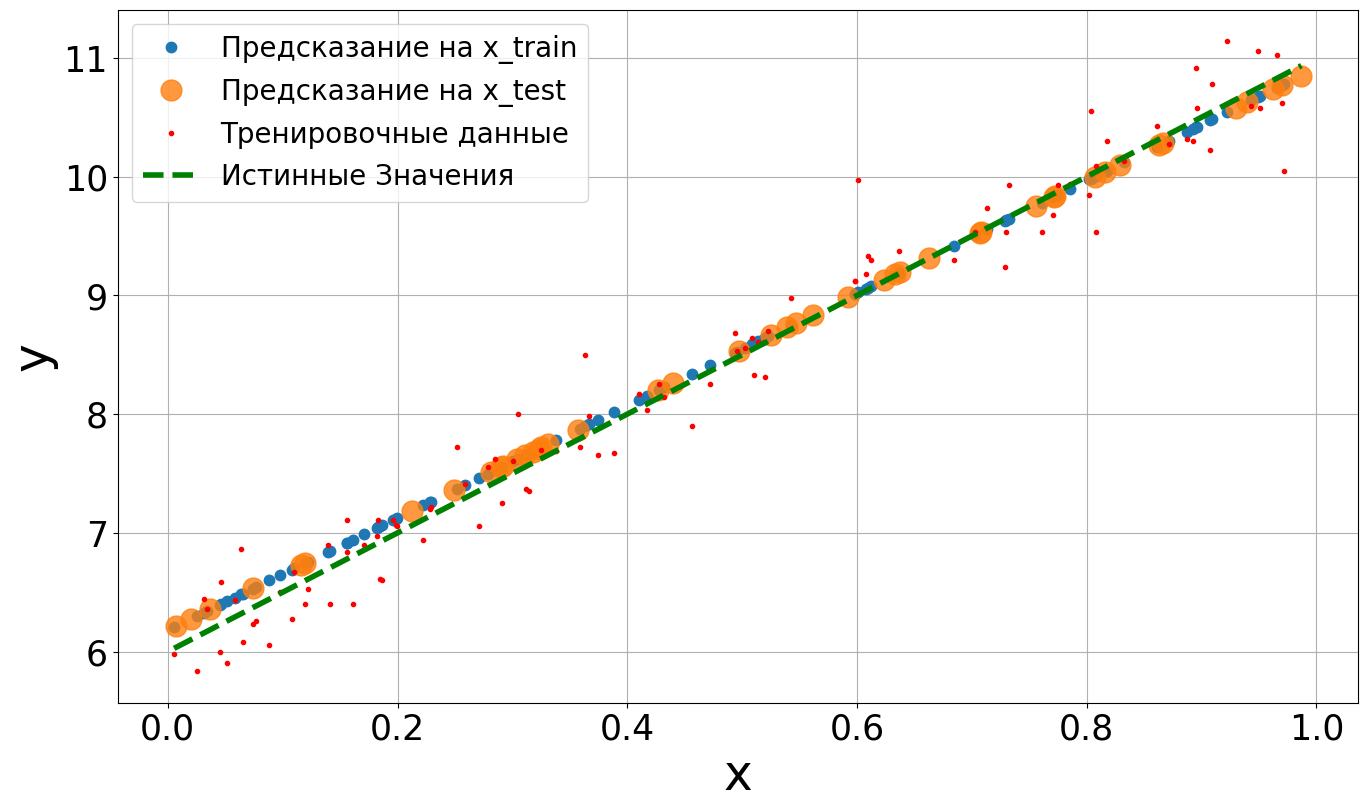

In [332]:
y, y_true, x = dataset(a = 5, b = 6,
                       f = None,  N = 150,
                       x_max = 1, 
                       noise_power = noise_power,
                       seed = 42)

regr_linear = RidgeRegression(learning_rate=0.1,
                        epochs=10,batch_size=10,
                        n_batches=None)

x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.3)
regr_linear.fit(x_train, y_train)

fig  = plt.figure(figsize=(16,9))
plot_model_class(x_train, y_train, x_test, x, y_true, regr_linear)

Применим регуляризацию лассо L1.

Опять же, всё плюс-минус тоже самое:

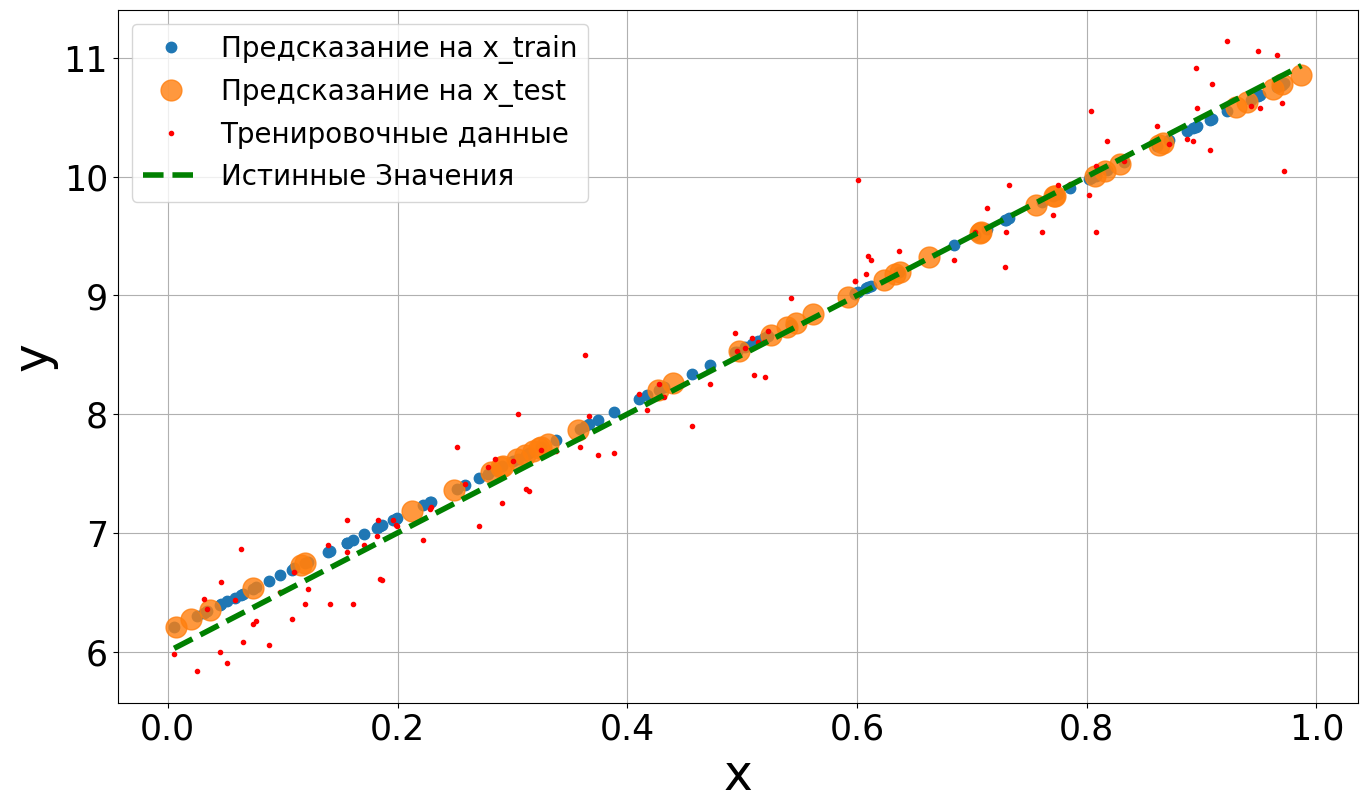

In [333]:
y, y_true, x = dataset(a = 5, b = 6,
                       f = None,  N = 150,
                       x_max = 1, 
                       noise_power = noise_power,
                       seed = 42)

regr_linear = LassoRegression(learning_rate=0.1,
                        epochs=10,batch_size=10,
                        n_batches=None)

x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.3)
regr_linear.fit(x_train, y_train)

fig  = plt.figure(figsize=(16,9))
plot_model_class(x_train, y_train, x_test, x, y_true, regr_linear)

### 1.2. Полиномиальая зависимость.

Сгенерируем полиномиальную зависимость 4 степени:

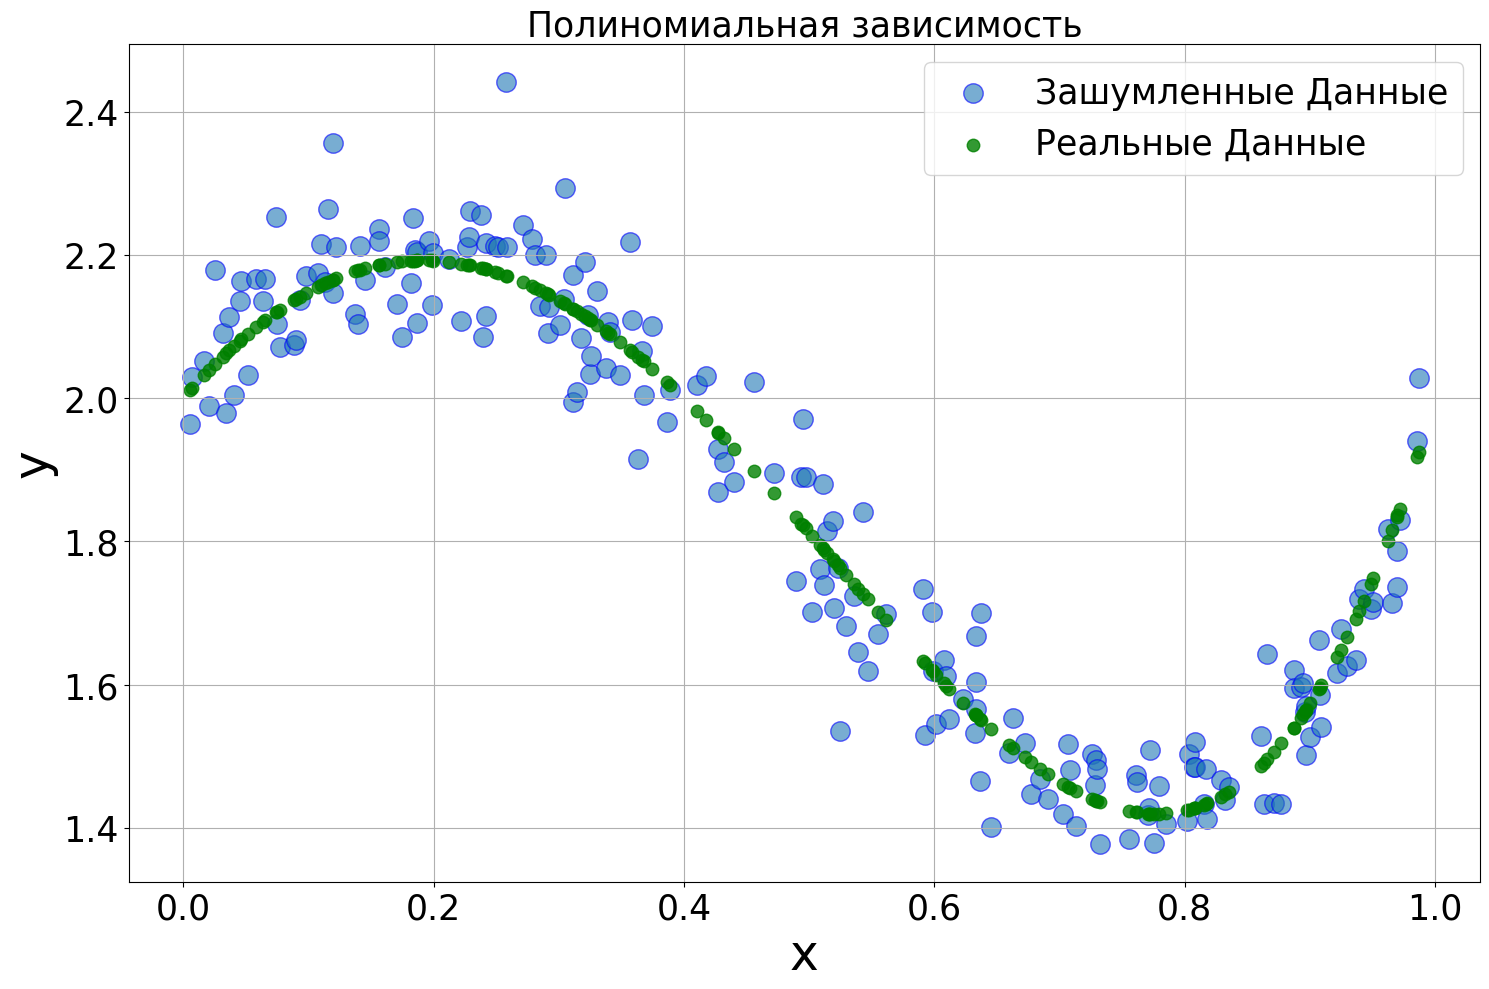

In [334]:
noise_power = 0.07

y, y_true, x = dataset(a = [2,-5,-2, 5], b = 2,
                       f = None,  N = 200,
                       x_max =1, 
                       noise_power = noise_power,
                       seed = 42)
vis_data(y, y_true,x, 'Полиномиальная зависимость')

Линейная регрессия, ожидаемо, на этих данных справляется так себе:

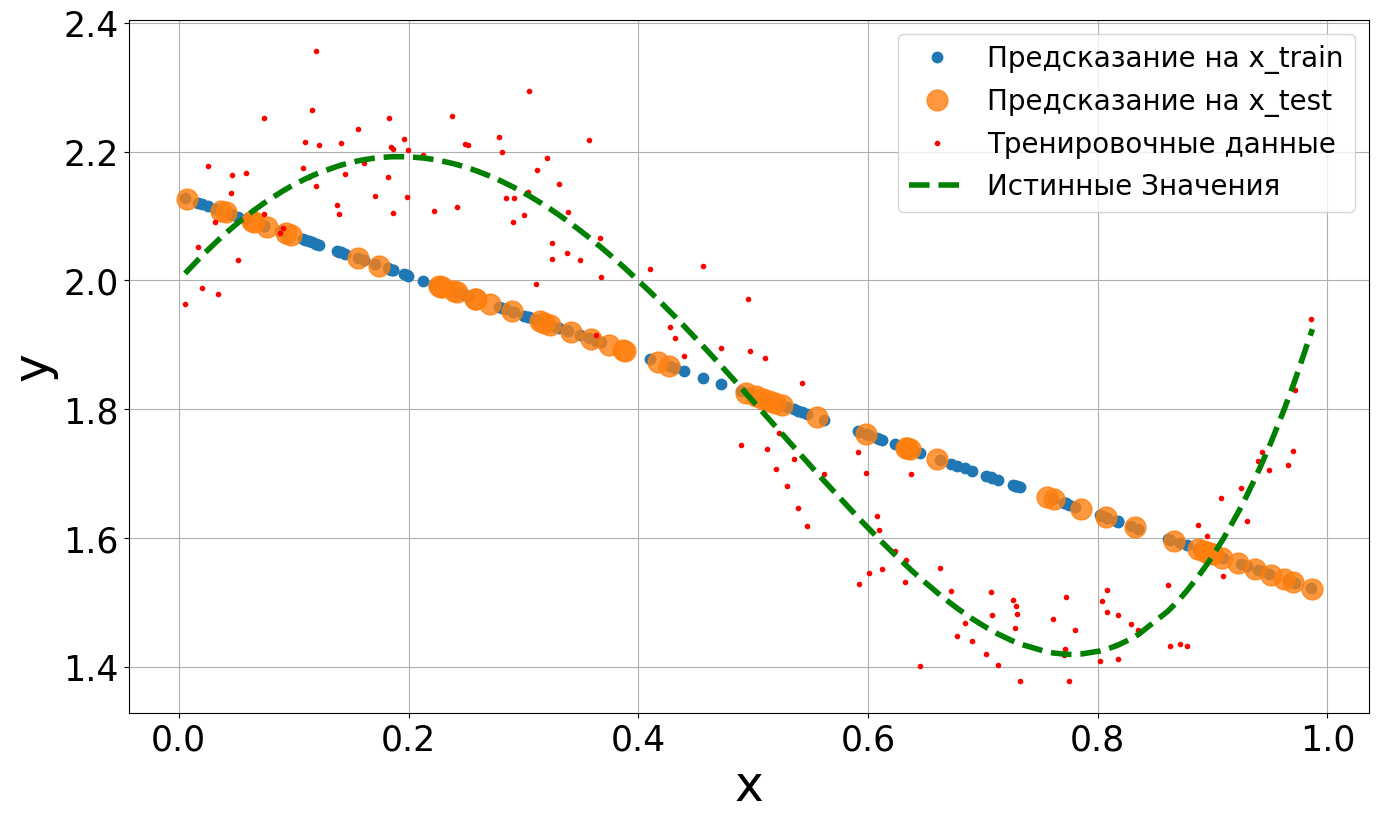

In [335]:
regr_linear_poly = LinearRegression(learning_rate=0.1,
                        epochs=10,batch_size=10,
                        n_batches=None)

x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.3)
regr_linear_poly.fit(x_train, y_train)

fig  = plt.figure(figsize=(16,9))
plot_model_class(x_train, y_train, x_test, x, y_true, regr_linear_poly)

Проверяю степенное приближение для данной зависимости. Видно, что при низких значениях числа эпох и скорости обучения приближение работает не очень хорошо:

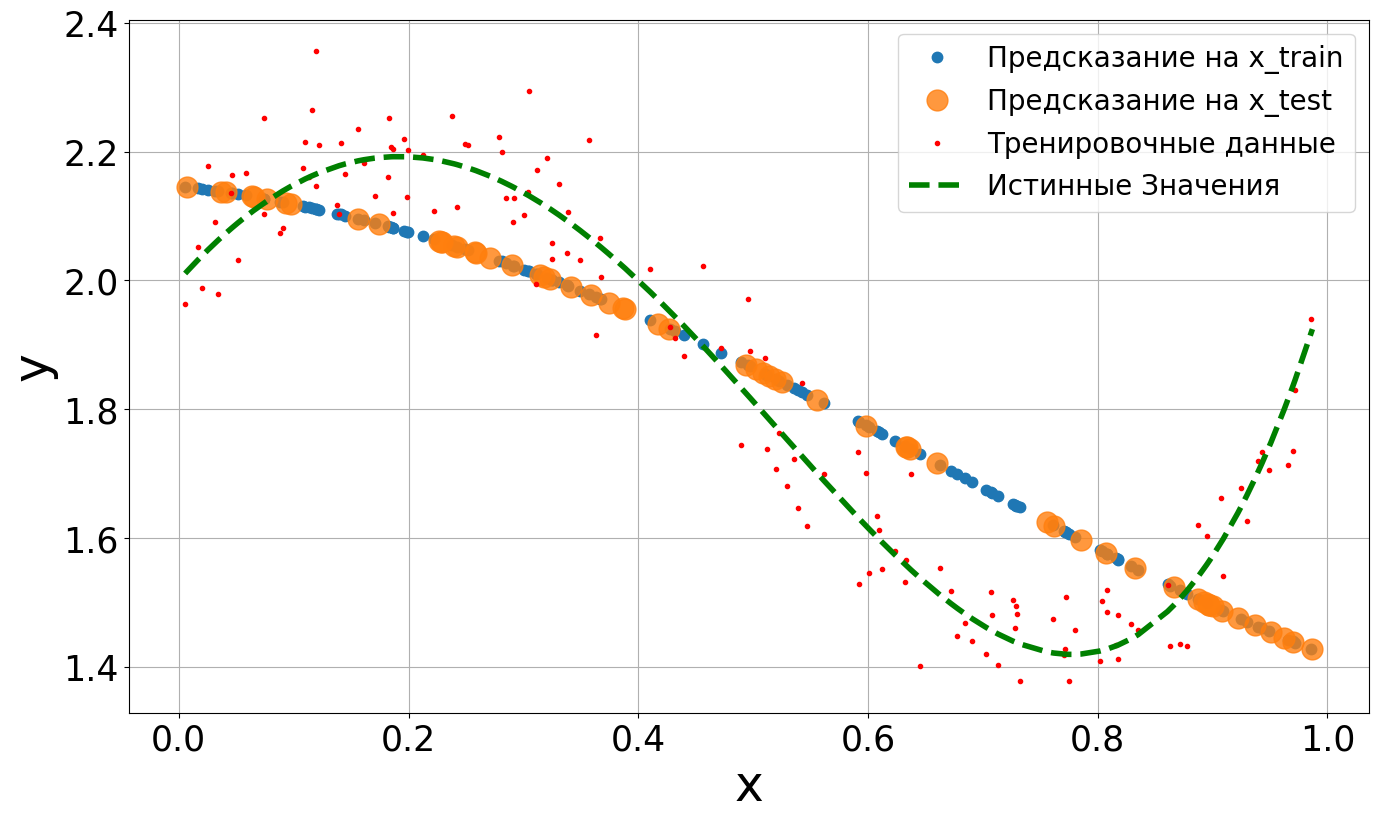

In [336]:
y, y_true, x = dataset(a = [2,-5,-2, 5], b = 2,
                       f = None,  N = 200,
                       x_max =1, 
                       noise_power = noise_power,
                       seed = 42)
x = to_polynom(x, order = 4)

regr_linear_poly = LinearRegression(learning_rate=0.1,
                        epochs=10,batch_size=10,
                        n_batches=None)

x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.3)
regr_linear_poly.fit(x_train, y_train)

fig  = plt.figure(figsize=(16,9))
plot_model_class(x_train, y_train, x_test, x, y_true, regr_linear_poly)

Увеличение числа степеней несколько улучшает картину, но результат всё ещё далек от идеала:

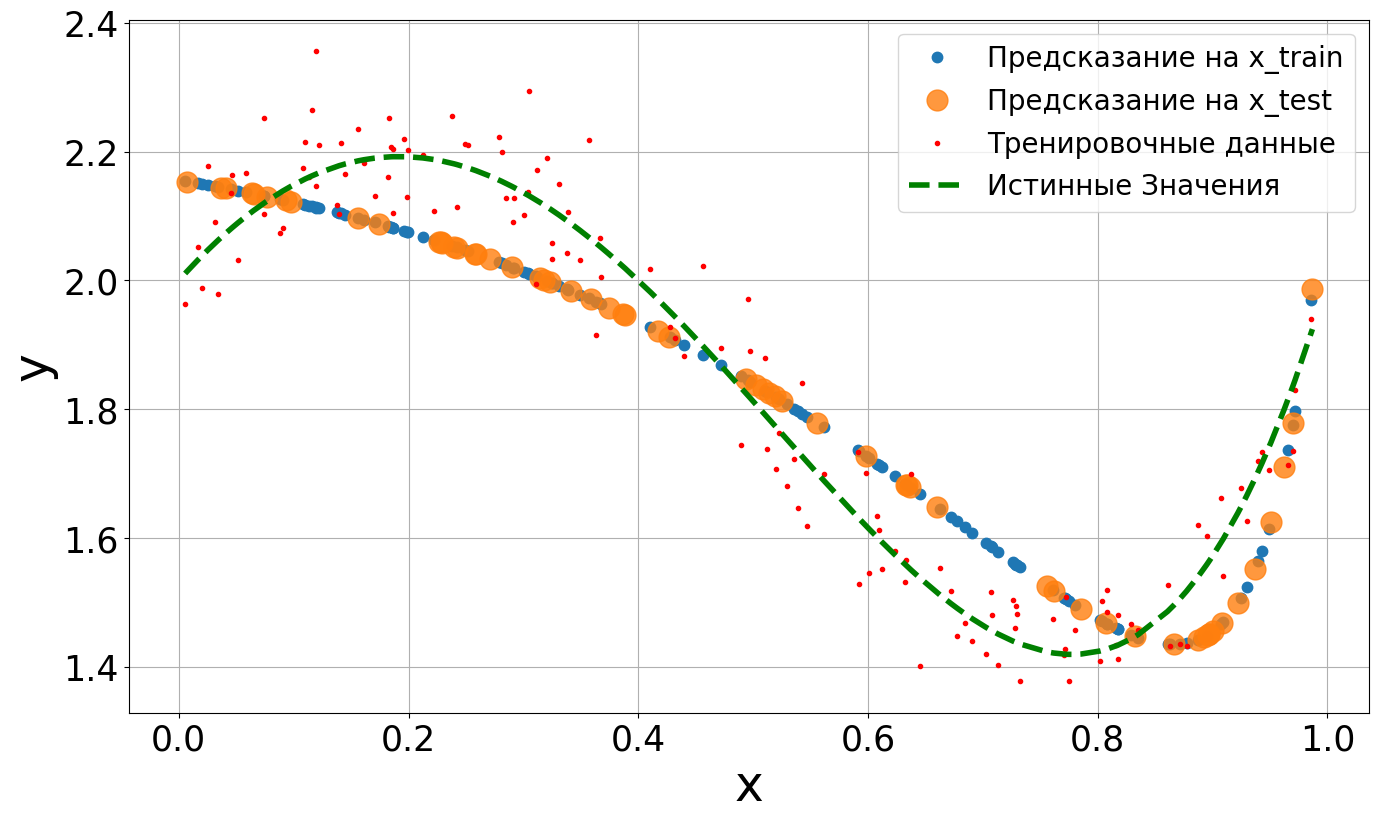

In [337]:
y, y_true, x = dataset(a = [2,-5,-2, 5], b = 2,
                       f = None,  N = 200,
                       x_max =1, 
                       noise_power = noise_power,
                       seed = 42)
x = to_polynom(x, order = 30)

regr_linear_poly = LinearRegression(learning_rate=0.1,
                        epochs=10,batch_size=10,
                        n_batches=None)

x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.3)
regr_linear_poly.fit(x_train, y_train)

fig  = plt.figure(figsize=(16,9))
plot_model_class(x_train, y_train, x_test, x, y_true, regr_linear_poly)

Теперь повысим число эпох и скорость обучения - видим уже значительно более приятный результат:

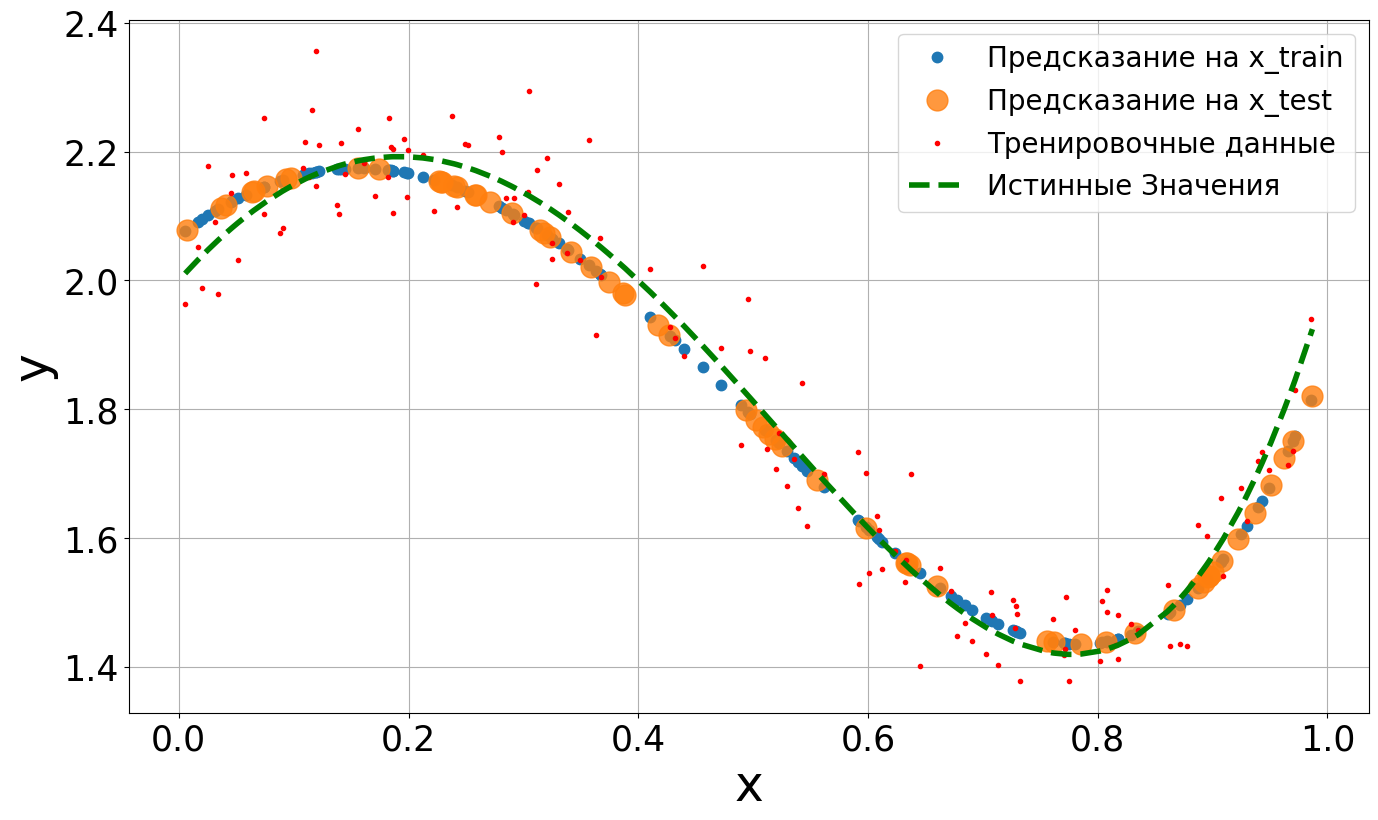

In [338]:
y, y_true, x = dataset(a = [2,-5,-2, 5], b = 2,
                       f = None,  N = 200,
                       x_max =1, 
                       noise_power = noise_power,
                       seed = 42)
x = to_polynom(x, order = 4)

regr_linear_poly = LinearRegression(learning_rate=0.2,
                        epochs=1000,batch_size=10,
                        n_batches=None)

x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.3)
regr_linear_poly.fit(x_train, y_train)

fig  = plt.figure(figsize=(16,9))
plot_model_class(x_train, y_train, x_test, x, y_true, regr_linear_poly)

Попробуем регуляризацию L2. Тут аналогично используем более высокие значения скорости обучения и числа эпох для более корректного приближения. Кажется, в данном случае применение L2 регуляризации почти никак не влияет на конечный результат:

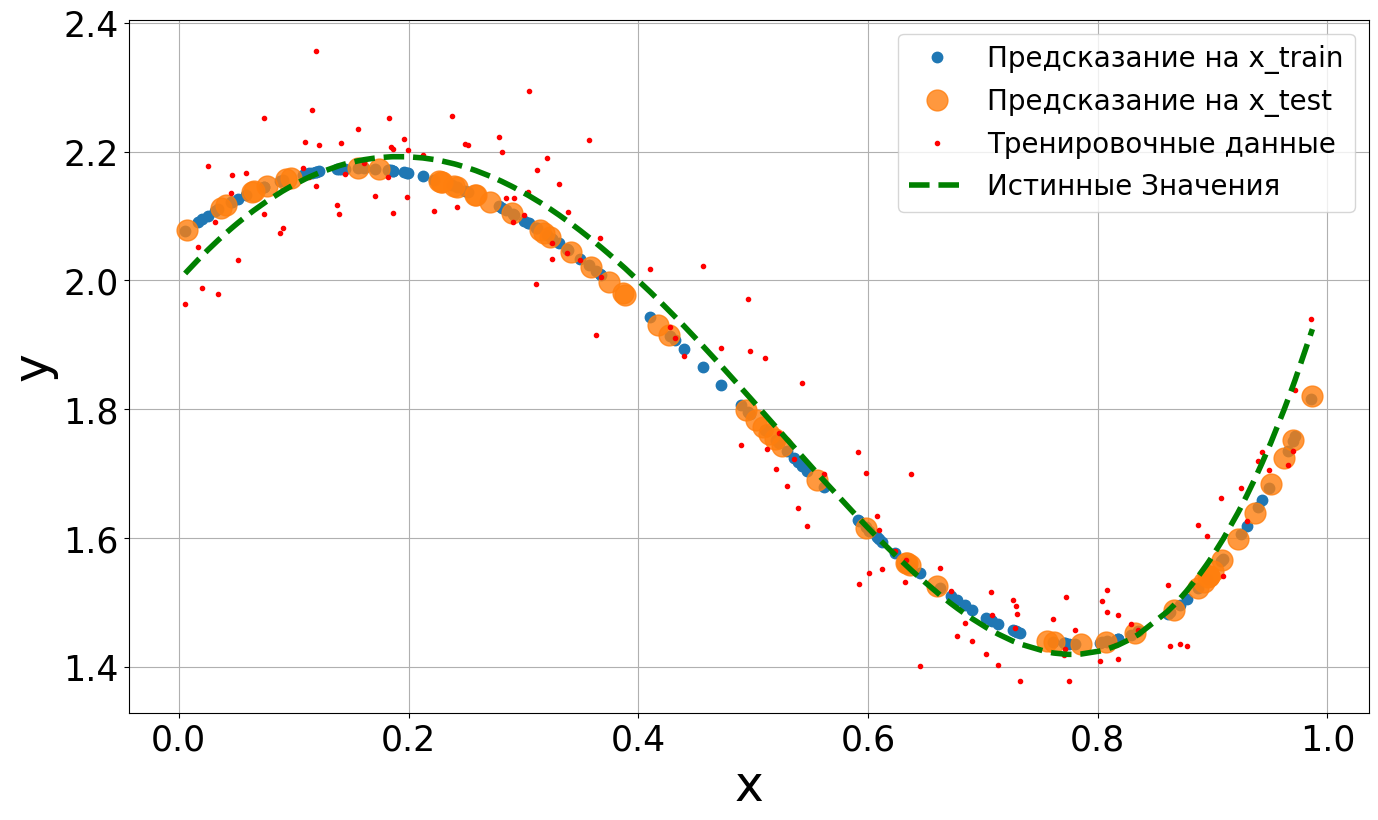

In [339]:
y, y_true, x = dataset(a = [2,-5,-2, 5], b = 2,
                       f = None,  N = 200,
                       x_max =1, 
                       noise_power = noise_power,
                       seed = 42)
x = to_polynom(x, order = 4)

regr_linear_poly = RidgeRegression(learning_rate=0.2,
                        epochs=1000,batch_size=10,
                        n_batches=None)

x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.3)
regr_linear_poly.fit(x_train, y_train)

fig  = plt.figure(figsize=(16,9))
plot_model_class(x_train, y_train, x_test, x, y_true, regr_linear_poly)

А вот регуляризация L1 даже при высоких значениях числа эпох и скорости обучения справляется уже значительно хуже:

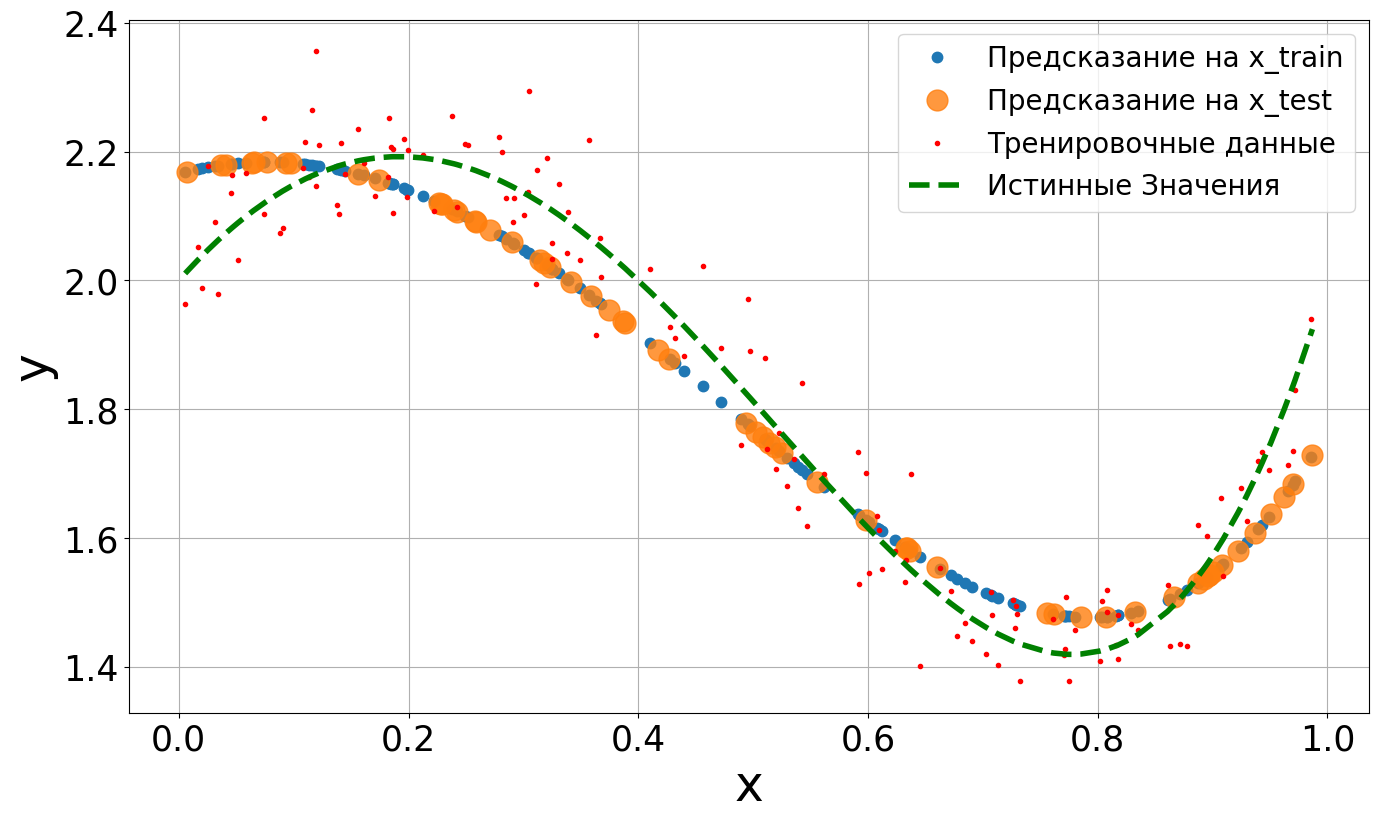

In [340]:
y, y_true, x = dataset(a = [2,-5,-2, 5], b = 2,
                       f = None,  N = 200,
                       x_max =1, 
                       noise_power = noise_power,
                       seed = 42)
x = to_polynom(x, order = 4)

regr_linear_poly = LassoRegression(learning_rate=0.2,
                        epochs=1000,batch_size=10,
                        n_batches=None)

x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.3)
regr_linear_poly.fit(x_train, y_train)

fig  = plt.figure(figsize=(16,9))
plot_model_class(x_train, y_train, x_test, x, y_true, regr_linear_poly)

### 1.3. Гармоническая зависимость.

Генерируем гармоническую зависимость:

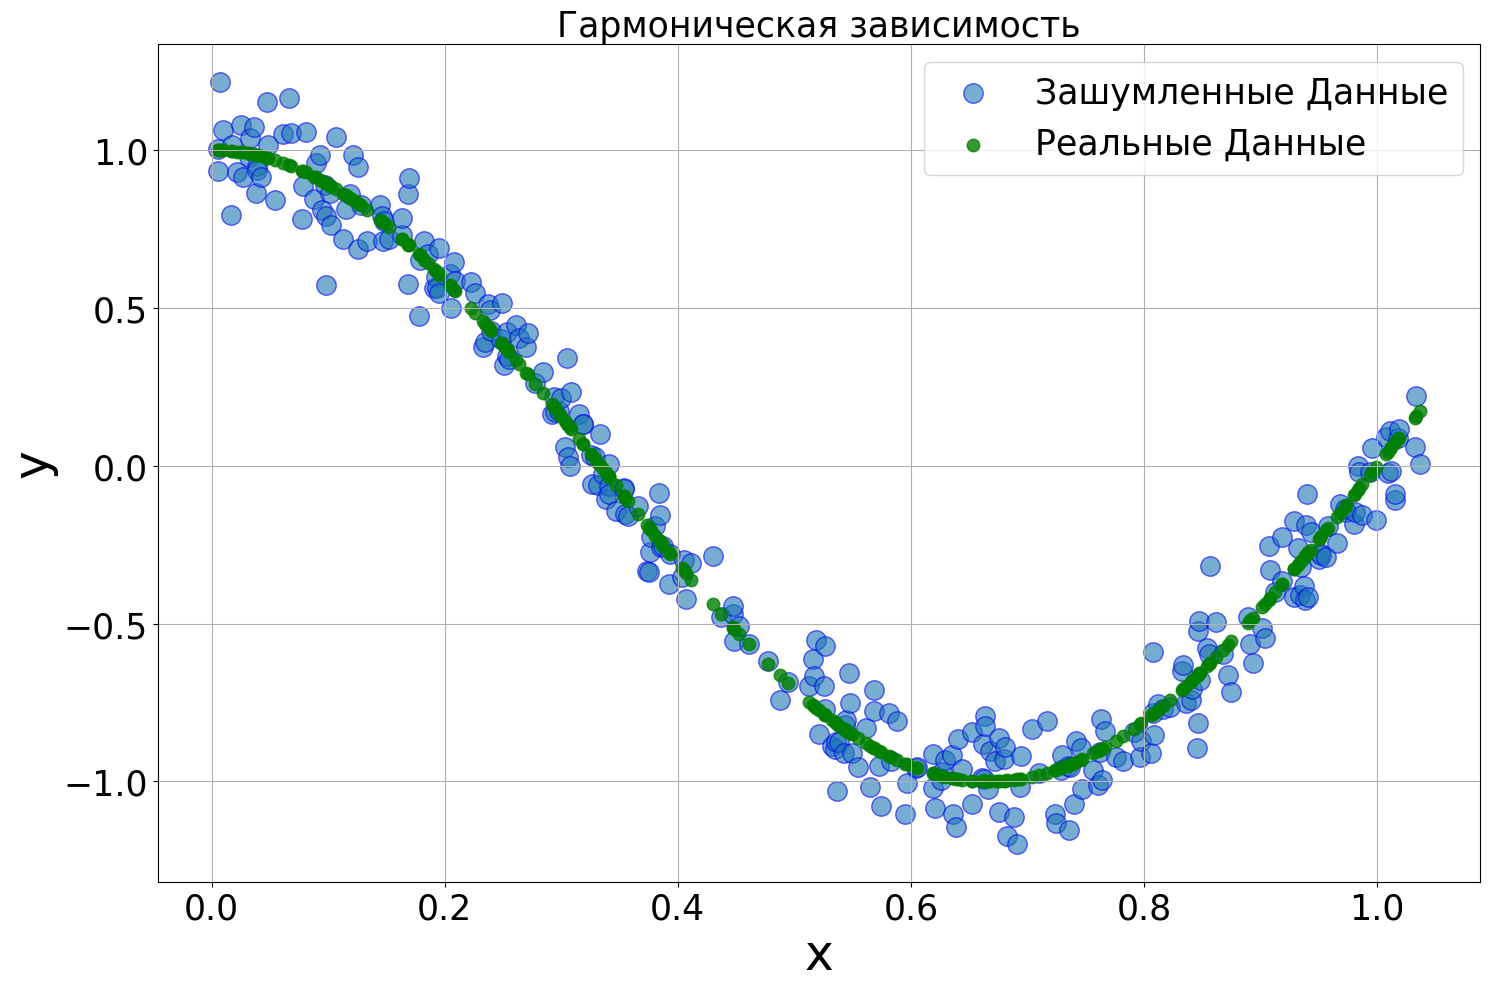

In [341]:
noise_power = 0.1

y, y_true, x = dataset(a = 3/2*np.pi,
                       b = 1/2*np.pi, f = np.sin,  
                       N = 300, x_max =np.pi/3, 
                       noise_power = noise_power, seed = 42)
vis_data(y, y_true,x, 'Гармоническая зависимость')

Линейная регрессия ожидаемо не справляется:

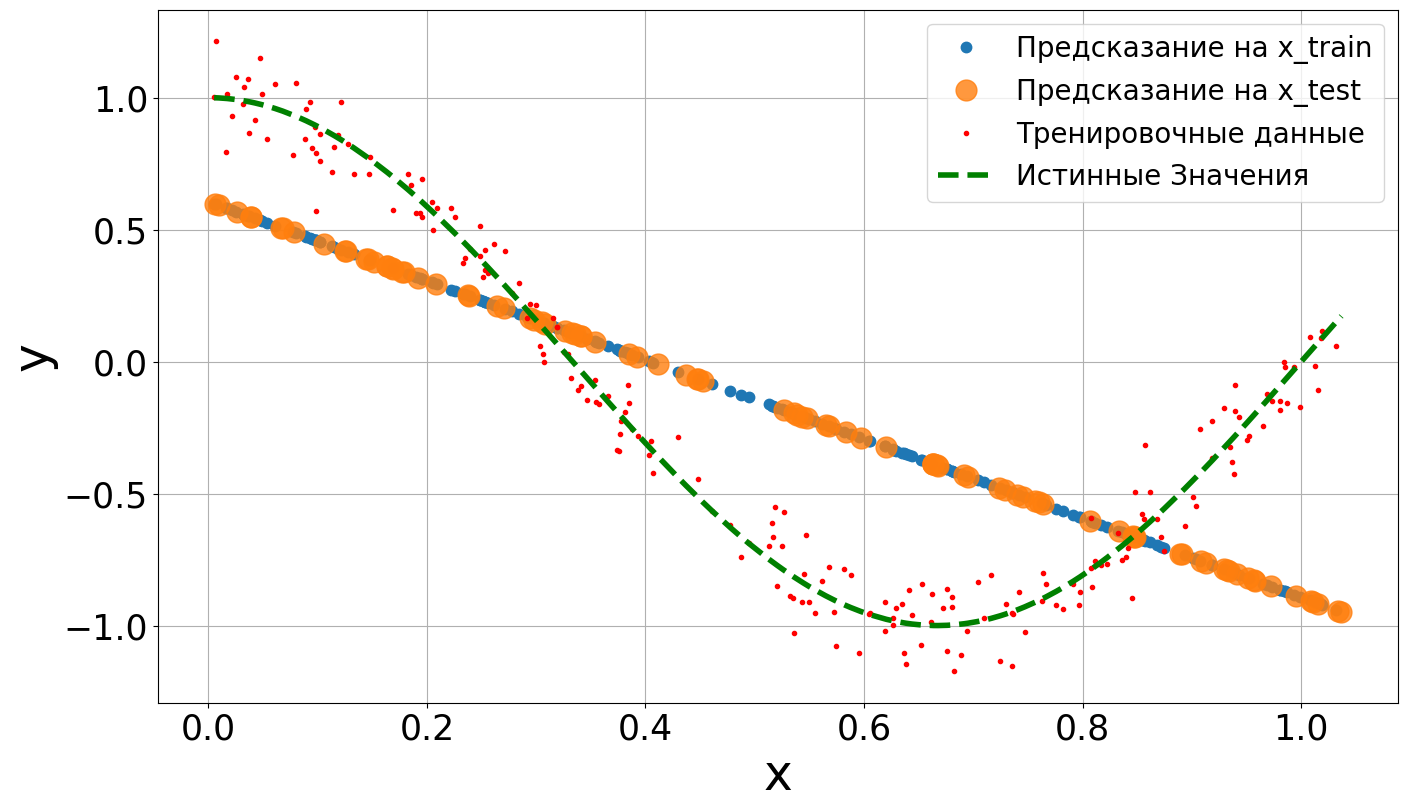

In [342]:
regr_harmonic = LinearRegression(learning_rate=0.1,
                        epochs=10,batch_size=10,
                        n_batches=None)

x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.3)
regr_harmonic.fit(x_train, y_train)

fig  = plt.figure(figsize=(16,9))
plot_model_class(x_train, y_train, x_test, x, y_true, regr_harmonic)

Полиномиальная пытается, но выходит не лучшим образом:

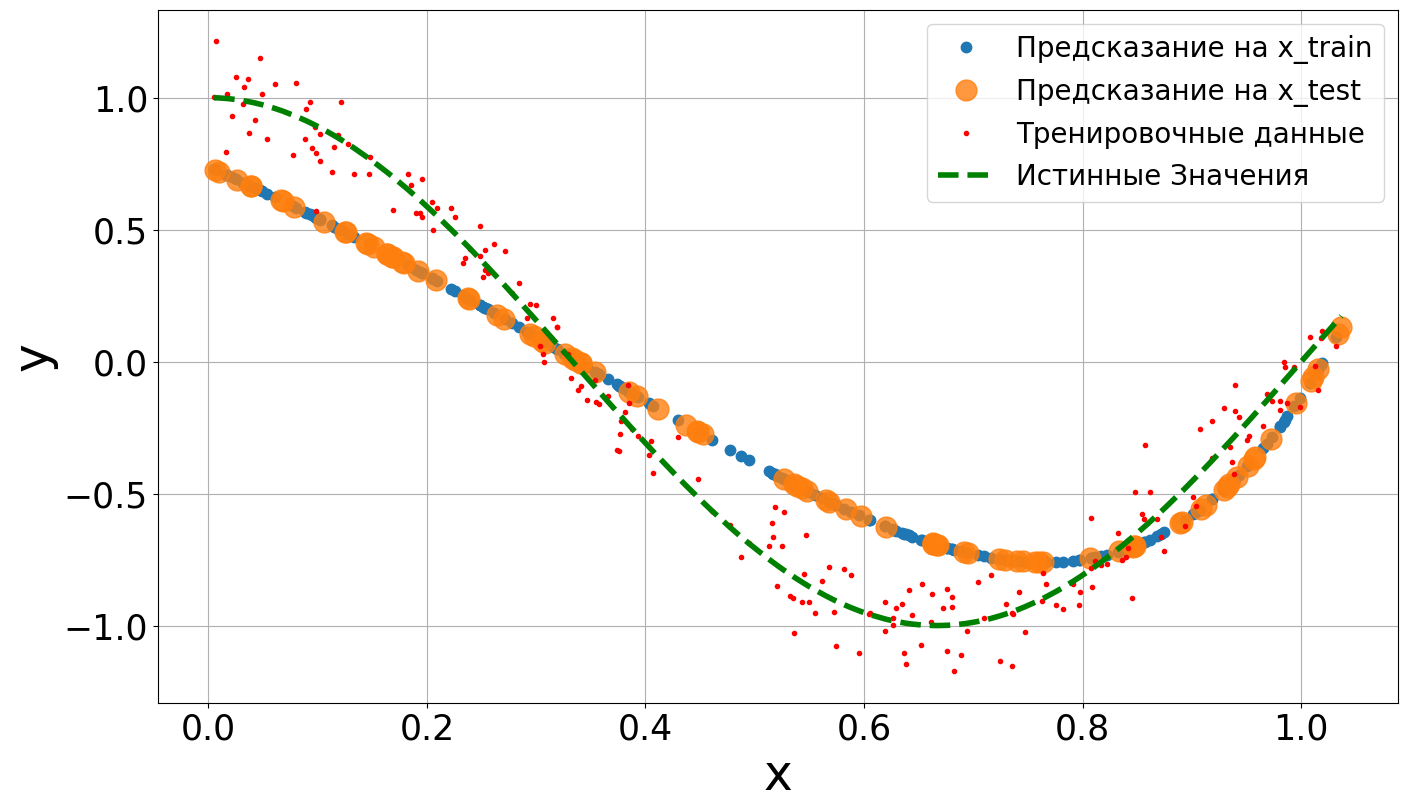

In [343]:
y, y_true, x = dataset(a = 3/2*np.pi,
                       b = 1/2*np.pi, f = np.sin,  
                       N = 300, x_max =np.pi/3, 
                       noise_power = noise_power, 
                       seed = 42)
x = to_polynom(x, order = 6)

regr_harmonic = LinearRegression(learning_rate=0.1,
                        epochs=10,batch_size=10,
                        n_batches=None)

x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.3)
regr_harmonic.fit(x_train, y_train)

fig  = plt.figure(figsize=(16,9))
plot_model_class(x_train, y_train, x_test, x, y_true, regr_harmonic)

Повышение числа эпох помогает лишь отчасти, на краях приближение не справляется:

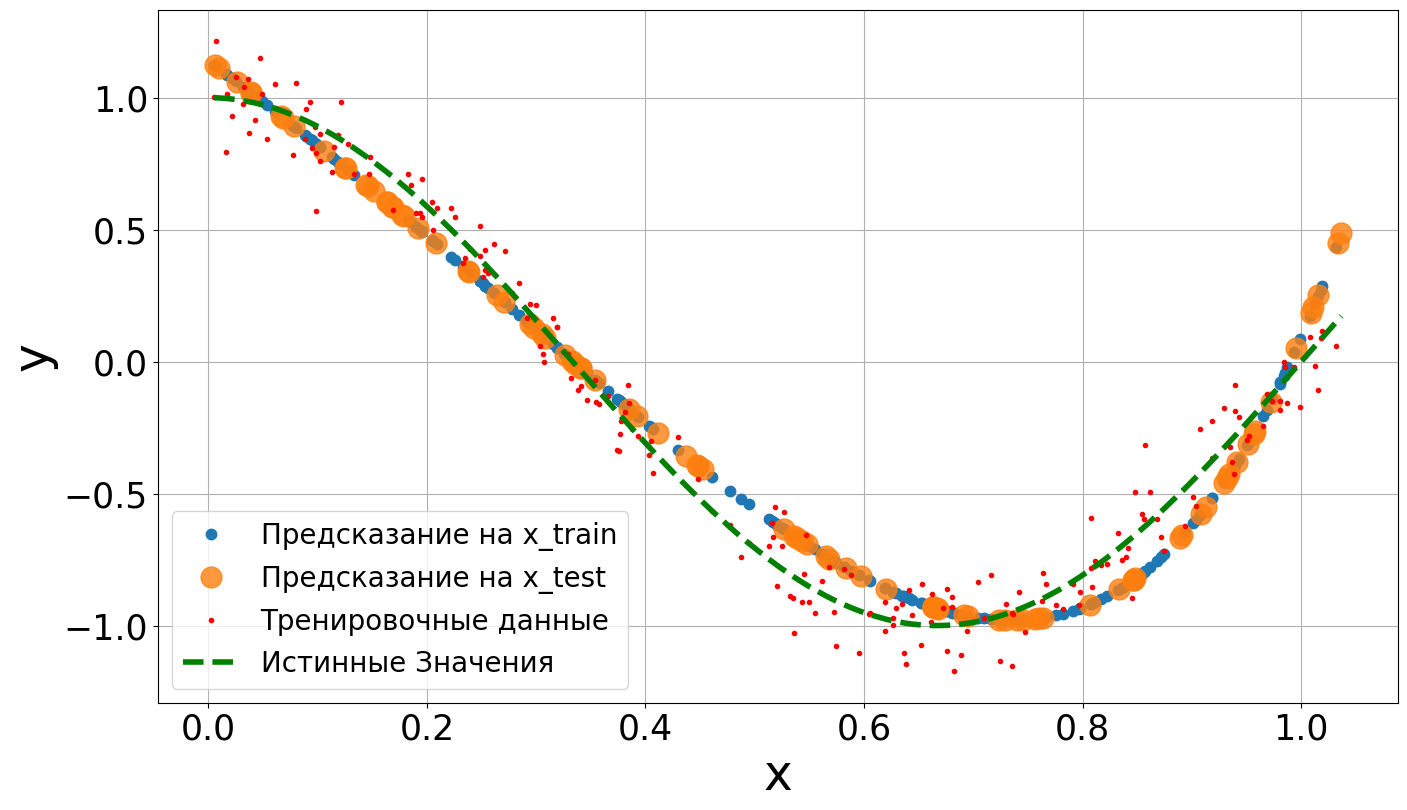

In [344]:
y, y_true, x = dataset(a = 3/2*np.pi,
                       b = 1/2*np.pi, f = np.sin,  
                       N = 300, x_max =np.pi/3, 
                       noise_power = noise_power, 
                       seed = 42)
x = to_polynom(x, order = 6)

regr_harmonic = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=10,
                        n_batches=None)

x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.3)
regr_harmonic.fit(x_train, y_train)

fig  = plt.figure(figsize=(16,9))
plot_model_class(x_train, y_train, x_test, x, y_true, regr_harmonic)

Регуляризации показывают примерно одинаковый результат:

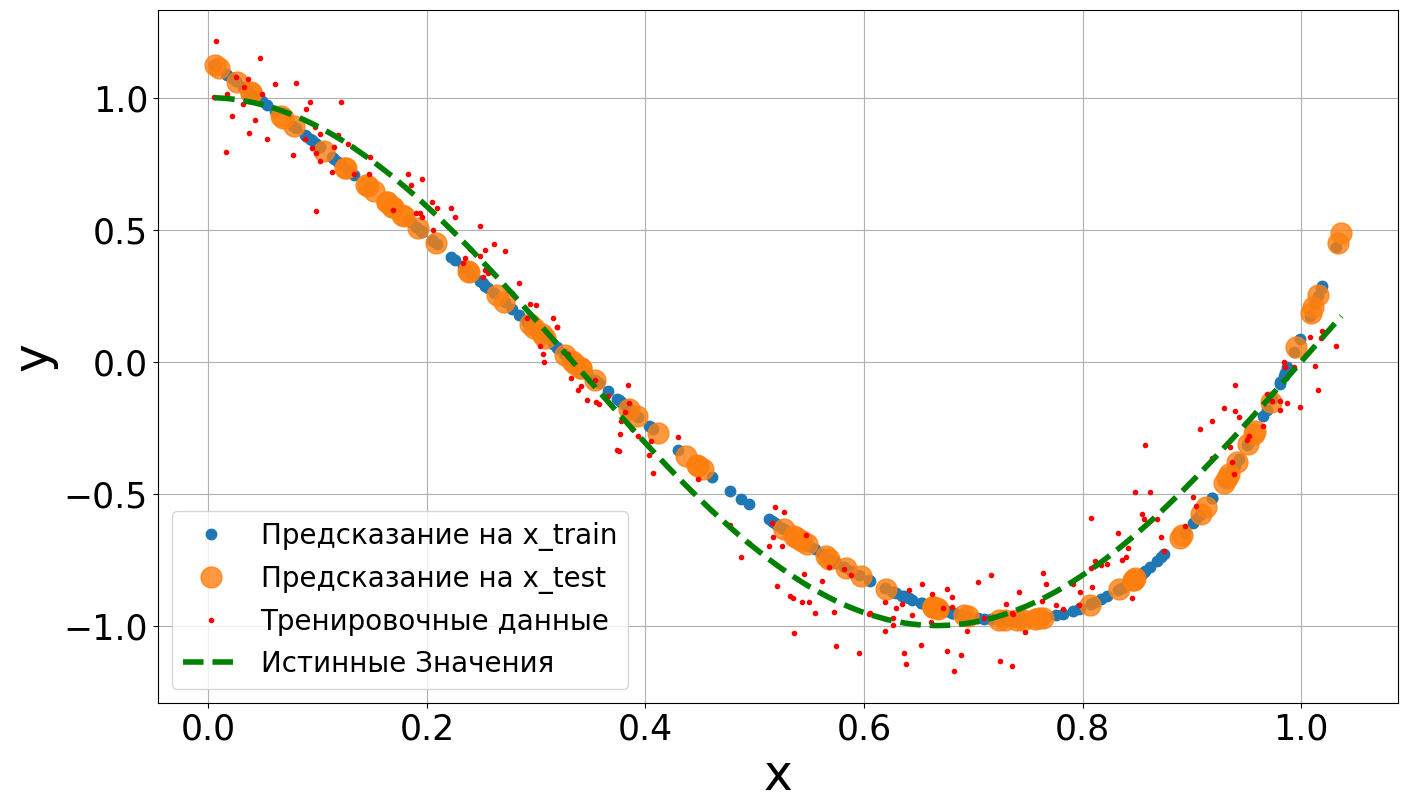

In [345]:
y, y_true, x = dataset(a = 3/2*np.pi,
                       b = 1/2*np.pi, f = np.sin,  
                       N = 300, x_max =np.pi/3, 
                       noise_power = noise_power, 
                       seed = 42)
x = to_polynom(x, order = 6)

regr_harmonic = RidgeRegression(learning_rate=0.1,
                        epochs=100,batch_size=10,
                        n_batches=None)

x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.3)
regr_harmonic.fit(x_train, y_train)

fig  = plt.figure(figsize=(16,9))
plot_model_class(x_train, y_train, x_test, x, y_true, regr_harmonic)

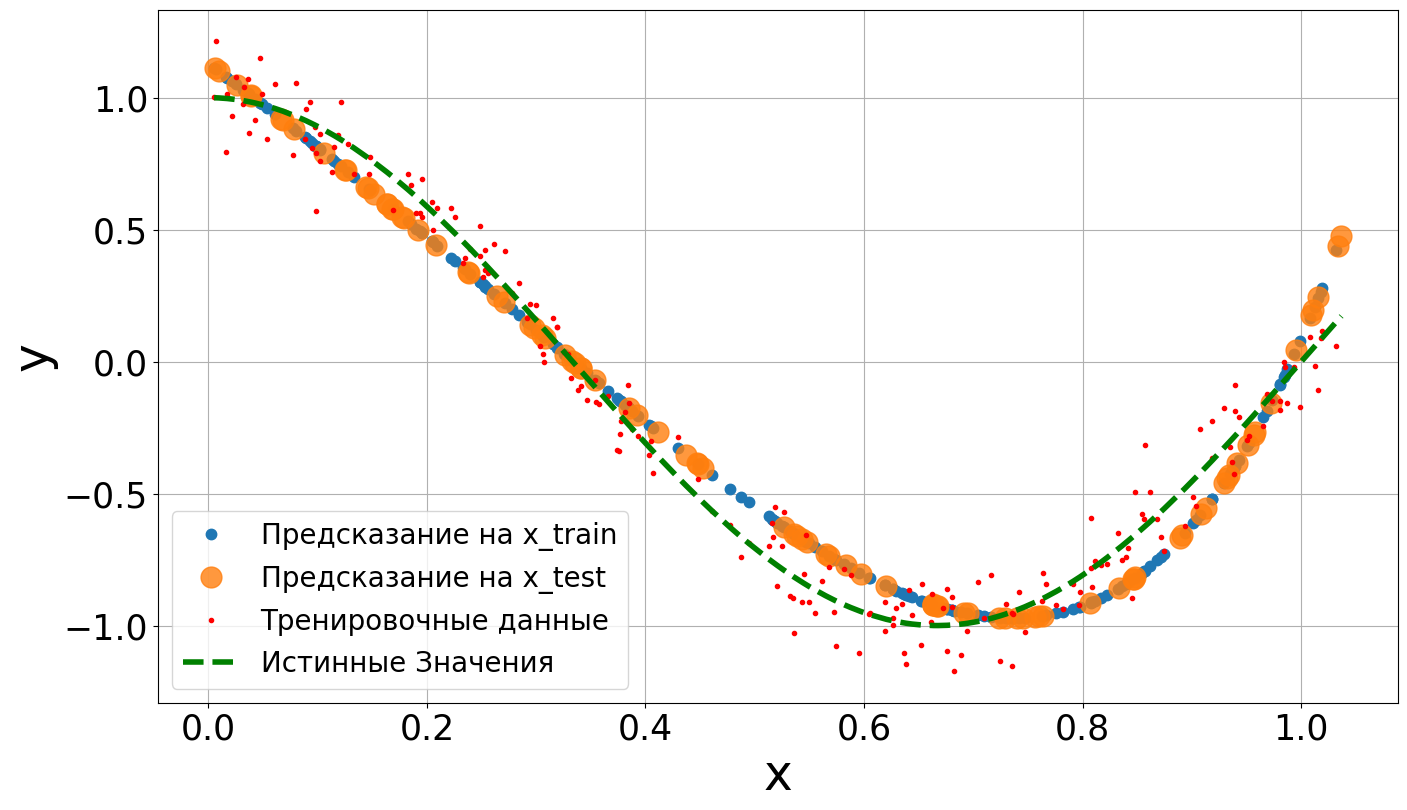

In [346]:
y, y_true, x = dataset(a = 3/2*np.pi,
                       b = 1/2*np.pi, f = np.sin,  
                       N = 300, x_max =np.pi/3, 
                       noise_power = noise_power, 
                       seed = 42)
x = to_polynom(x, order = 6)

regr_harmonic = LassoRegression(learning_rate=0.1,
                        epochs=100,batch_size=10,
                        n_batches=None)

x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.3)
regr_harmonic.fit(x_train, y_train)

fig  = plt.figure(figsize=(16,9))
plot_model_class(x_train, y_train, x_test, x, y_true, regr_harmonic)

На этом работу с синтетическими данными закончим и перейдем к нашим машинкам.

## 2. Cars Moldova.

Для последующей работы загрузим датасеты из прошлого задания:

In [347]:
df_3 = pd.read_csv('content/cars_moldova_df3.csv')
df_3_scaled = pd.read_csv('content/cars_moldova_df3_scaled.csv')
df_3_norm = pd.read_csv('content/cars_moldova_df3_norm.csv')
df_3_power = pd.read_csv('content/cars_moldova_df3_power.csv')
df_3_dummies_style = pd.read_csv('content/cars_moldova_df3_dummies_style.csv')

Сделаем работу за себя в прошлом и удалим лишний столбец 'Year' из каждого датасета:

In [348]:
df_3 = df_3.drop('Year', axis=1)
df_3_scaled = df_3_scaled.drop('Year', axis=1)
df_3_norm = df_3_norm.drop('Year', axis=1)
df_3_power = df_3_power.drop('Year', axis=1)
df_3_dummies_style = df_3_dummies_style.drop('Year', axis=1)

### 2.1. Поработаем с обычным датасетом

Воспользуемся предварительно необработанным датасетом.
Наш целевой параметр - цена, нам нужно узнать влияние на неё других факторов. Для начала вычленим числовые и категориальные признаки в отдельные переменные:

In [349]:
df_3_num = df_3.select_dtypes(['number'])
df_3_other = df_3.select_dtypes(['object', 'category'])

#### Попробуем использовать линейную регрессию и нормализацию:

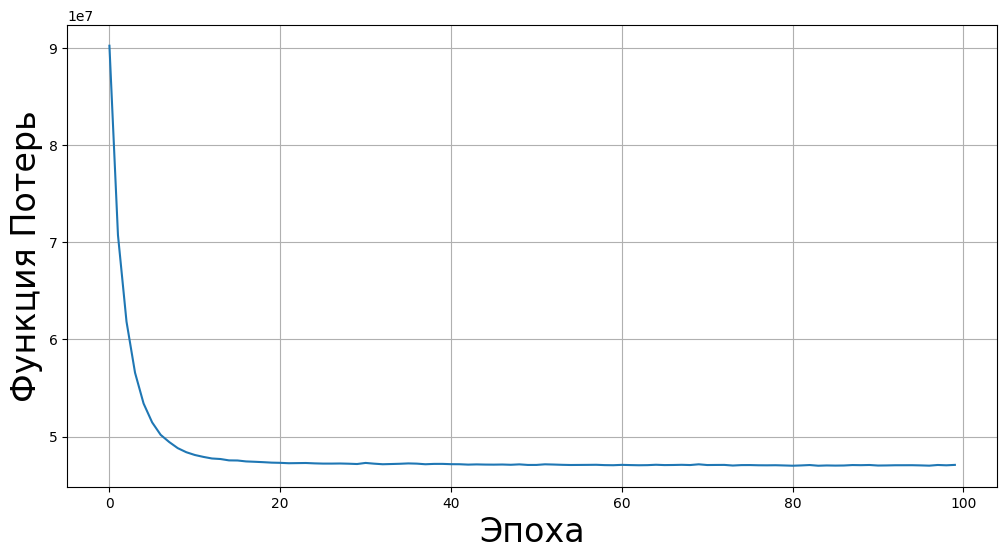

train R2: 0.4954; test R2: 0.4874


In [350]:
x, y = df_3_num.drop(columns = ['Price(euro)']).values, df_3_num['Price(euro)'].values

features_names = df_3_num.drop(columns = ['Price(euro)']).columns

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

scaler  = MinMaxScaler()
scaler.fit_transform(x_train)
x_train = scaler.transform(x_train) 
x_test  = scaler.transform(x_test) 

regr_linear = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=500,
                        n_batches=None)

regr_linear.fit(x_train, y_train)
regr_linear.plot_cost()
print( 'train R2: %.4f; test R2: %.4f' % (regr_linear.score(x_train, y_train), regr_linear.score(x_test, y_test)))

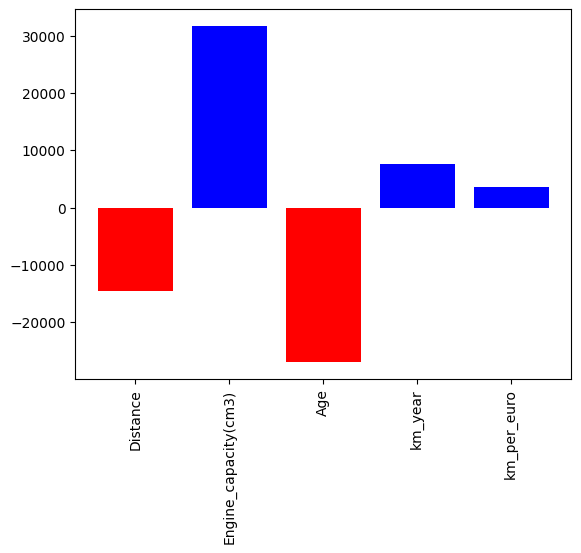

In [351]:
w, b = regr_linear.get_w_and_b()

vis_weigths(w, features_names)

#### Теперь используем стандартизацию:

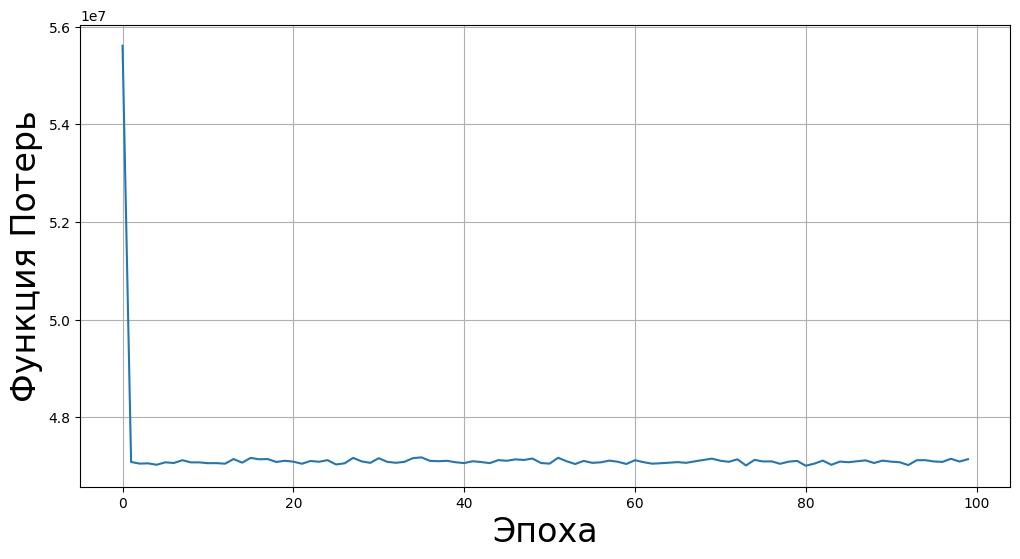

train R2: 0.4945; test R2: 0.4850


In [352]:
x, y = df_3_num.drop(columns = ['Price(euro)']).values, df_3_num['Price(euro)'].values

features_names = df_3_num.drop(columns = ['Price(euro)']).columns

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

scaler  = StandardScaler()
scaler.fit_transform(x_train)
x_train = scaler.transform(x_train) 
x_test  = scaler.transform(x_test) 

regr_linear = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=500,
                        n_batches=None)

regr_linear.fit(x_train, y_train)
regr_linear.plot_cost()
print( 'train R2: %.4f; test R2: %.4f' % (regr_linear.score(x_train, y_train), regr_linear.score(x_test, y_test)))

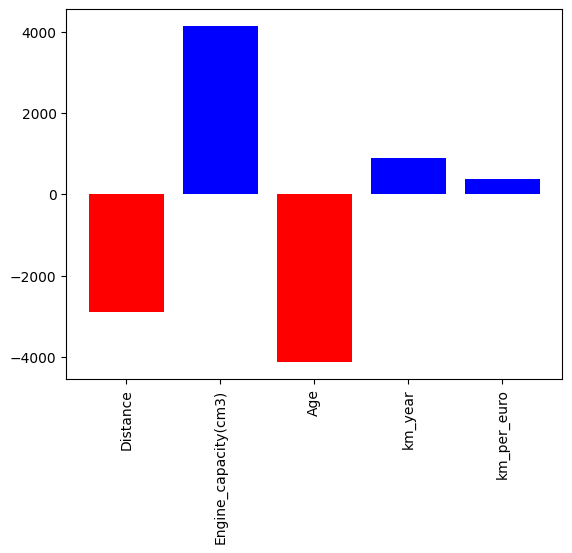

In [353]:
w, b = regr_linear.get_w_and_b()

vis_weigths(w, features_names)

Видим, что в данном случае изменилась шкала весов, а также несколько поменялось соотношение их величин.

Для обоих случаев R2 для тестовых и реальных данных очень близки и примерно составляют 0.48 - 0.49.

## 2.2. Нормализованный датасет

Теперь воспользуемся предварительно нормализованным датасетом:

In [354]:
df_3_norm_num = df_3_norm.select_dtypes(['number'])
df_3_norm_other = df_3_norm.select_dtypes(['object', 'category'])

In [355]:
df_3_norm_num.head(3)

,Distance,Engine_capacity(cm3),Price(euro),Age,km_year,km_per_euro
0,0.389878,0.333333,0.075651,0.20,0.353246,0.02016
1,0.269854,0.270833,0.083667,0.14,0.336172,0.01264
2,0.219844,0.270833,0.063627,0.18,0.218437,0.01344


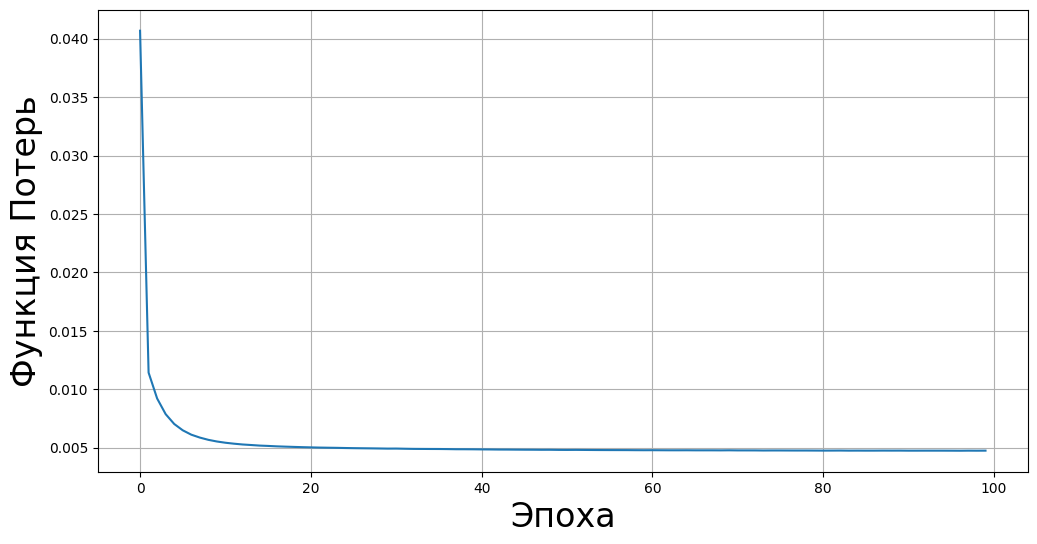

train R2: 0.4942; test R2: 0.4866


In [356]:
x, y = df_3_norm_num.drop(columns = ['Price(euro)']).values, df_3_norm_num['Price(euro)'].values

features_names = df_3_norm_num.drop(columns = ['Price(euro)']).columns

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

regr_linear = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=500,
                        n_batches=None)

regr_linear.fit(x_train, y_train)
regr_linear.plot_cost()
print( 'train R2: %.4f; test R2: %.4f' % (regr_linear.score(x_train, y_train), regr_linear.score(x_test, y_test)))

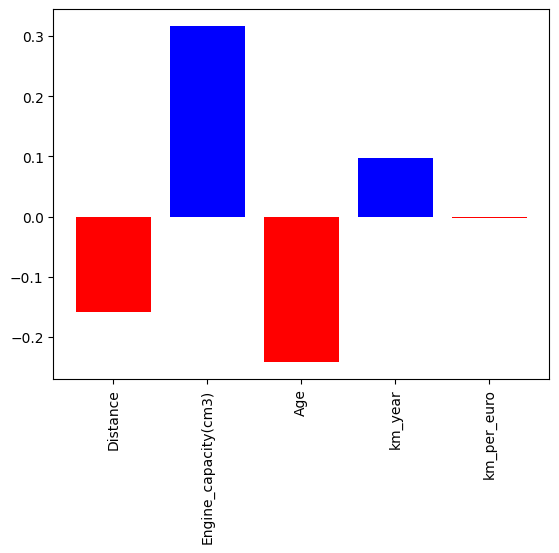

In [357]:
w, b = regr_linear.get_w_and_b()
vis_weigths(w, features_names)

Показатели R2 остались теми же, однако поменялось соотношение весов. Тем не менее, общие тенденции остались такими же, как и до преобразования.

## 2.3. Стандартизованный датасет

Теперь воспользуемся предварительно стандартизованным датасетом:

In [358]:
df_3_scaled_num = df_3_scaled.select_dtypes(['number'])
df_3_scaled_other = df_3_scaled.select_dtypes(['object', 'category'])

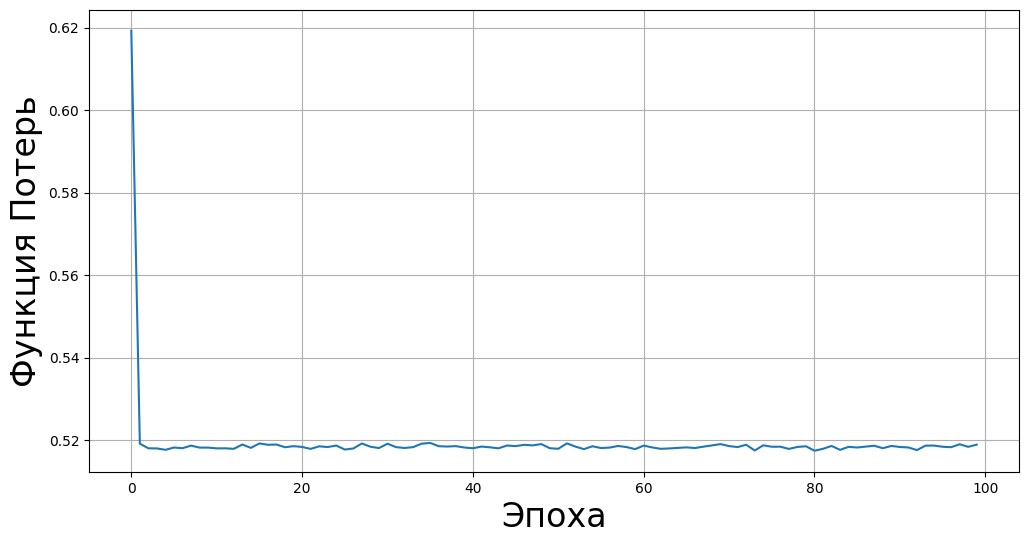

train R2: 0.4945; test R2: 0.4850


In [359]:
x, y = df_3_scaled_num.drop(columns = ['Price(euro)']).values, df_3_scaled_num['Price(euro)'].values

features_names = df_3_scaled_num.drop(columns = ['Price(euro)']).columns

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

regr_linear = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=500,
                        n_batches=None)

regr_linear.fit(x_train, y_train)
regr_linear.plot_cost()
print( 'train R2: %.4f; test R2: %.4f' % (regr_linear.score(x_train, y_train), regr_linear.score(x_test, y_test)))

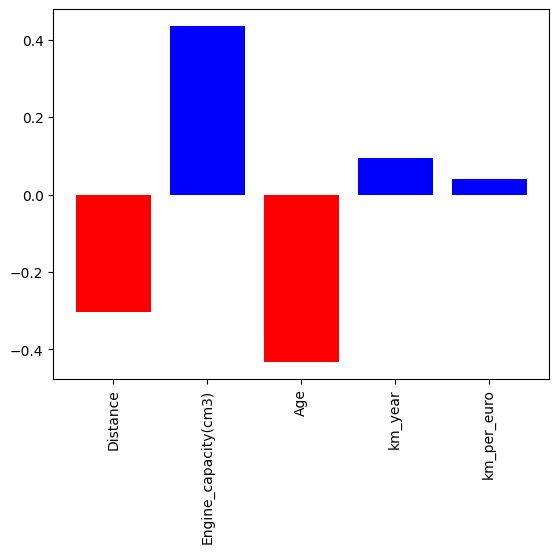

In [360]:
w, b = regr_linear.get_w_and_b()
vis_weigths(w, features_names)

Показатели R2 остались теми же, однако что-то явно произошло с соотношением весов. Возраст поменял знак своего веса. Что-то странное, раньше такого не было...

## 2.4. Датасет со степенным преобразованием

Теперь воспользуемся датасетом со степенным преобразованием:

In [361]:
df_3_power_num = df_3_power.select_dtypes(['number'])
df_3_power_other = df_3_power.select_dtypes(['object', 'category'])

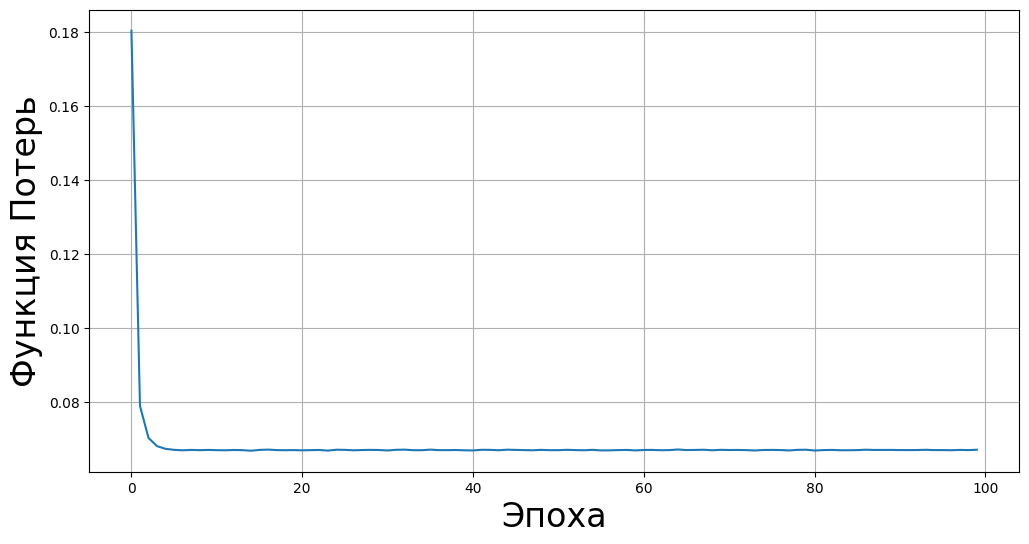

train R2: 0.9344; test R2: 0.9315


In [362]:
x, y = df_3_power_num.drop(columns = ['Price(euro)']).values, df_3_power_num['Price(euro)'].values

features_names = df_3_power_num.drop(columns = ['Price(euro)']).columns

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

regr_linear = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=500,
                        n_batches=None)

regr_linear.fit(x_train, y_train)
regr_linear.plot_cost()
print( 'train R2: %.4f; test R2: %.4f' % (regr_linear.score(x_train, y_train), regr_linear.score(x_test, y_test)))

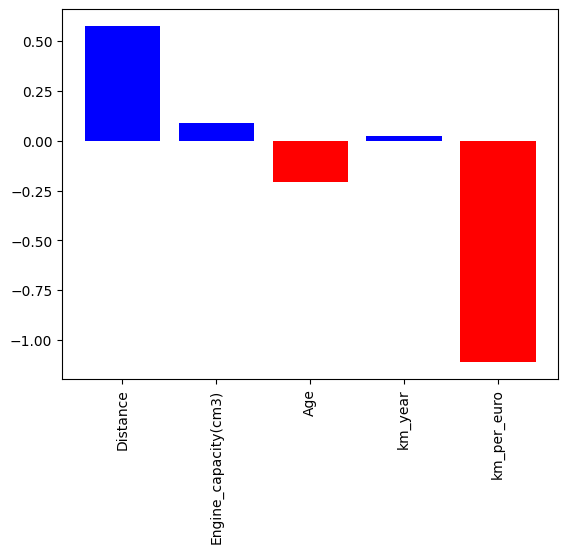

In [363]:
w, b = regr_linear.get_w_and_b()
vis_weigths(w, features_names)

Здесь видим совершенно иное распределение весов в модели, а также очень высокие показатели оценки R2. Я затрудняюсь дать точное объяснение такому сильному влиянию степенного преобразования, однако предположу, что это связано с приведением значений к виду нормального распределения. 

Сравним корреляции для датасета без обработки и со степенным преобразованием:

In [364]:
cm = sns.color_palette("vlag", as_cmap=True)

df_3_num.corr(numeric_only=True).style.background_gradient(cmap=cm, vmin = -1, vmax=1)

,Distance,Engine_capacity(cm3),Price(euro),Age,km_year,km_per_euro
Distance,1.000000,0.073667,-0.358394,0.431808,0.446685,0.521332
Engine_capacity(cm3),0.073667,1.000000,0.383766,0.026269,-0.010049,-0.105446
Price(euro),-0.358394,0.383766,1.000000,-0.551700,0.164468,-0.417911
Age,0.431808,0.026269,-0.551700,1.000000,-0.443895,0.614983
km_year,0.446685,-0.010049,0.164468,-0.443895,1.000000,-0.107021
km_per_euro,0.521332,-0.105446,-0.417911,0.614983,-0.107021,1.000000


Видим, что с помощью степенного преобразования нам удалось увеличить контрастность нашей таблицы (сделать зависимости более явными), при этом оставив закономерности всё теми же. Веса модели же очень сильно поменялись в том числе по знаку, что я пока что объяснить не могу... 

In [365]:
cm = sns.color_palette("vlag", as_cmap=True)

df_3_power_num.corr(numeric_only=True).style.background_gradient(cmap=cm, vmin = -1, vmax=1)

,Distance,Engine_capacity(cm3),Price(euro),Age,km_year,km_per_euro
Distance,1.000000,0.062568,-0.327767,0.485827,0.516488,0.748580
Engine_capacity(cm3),0.062568,1.000000,0.325695,0.013178,0.004988,-0.186155
Price(euro),-0.327767,0.325695,1.000000,-0.768691,0.341198,-0.840378
Age,0.485827,0.013178,-0.768691,1.000000,-0.398725,0.755462
km_year,0.516488,0.004988,0.341198,-0.398725,1.000000,0.061975
km_per_euro,0.748580,-0.186155,-0.840378,0.755462,0.061975,1.000000


## 2.5. Датасет c One-Hot преобразованием

Рассмотрим датасет с One-Hot закодированным столбцом style:

In [366]:
df_3_dummies_style_num = df_3_dummies_style.select_dtypes(['number'])
df_3_dummies_style_other = df_3_dummies_style.select_dtypes(['object', 'category'])

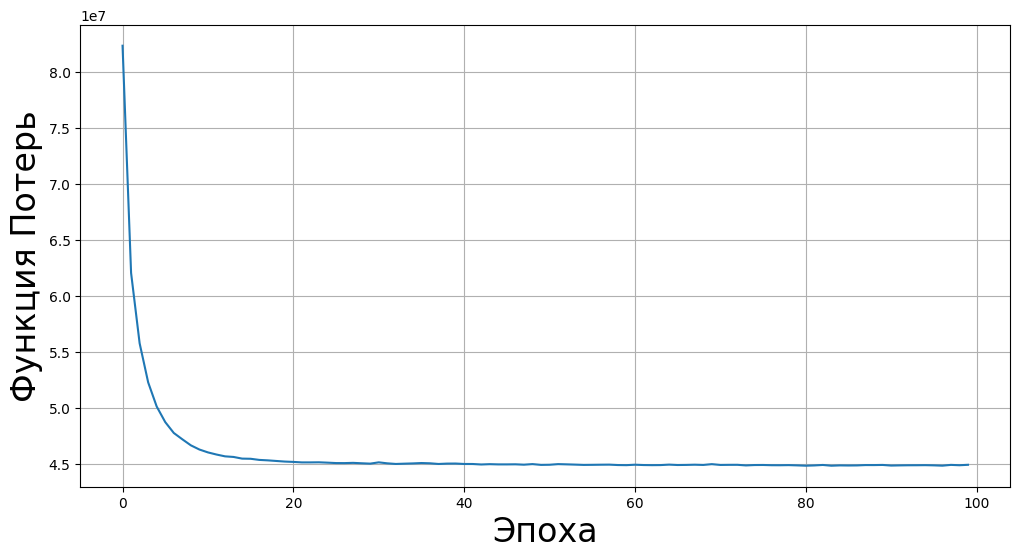

train R2: 0.5187; test R2: 0.5134


In [367]:
x, y = df_3_dummies_style_num.drop(columns = ['Price(euro)']).values, df_3_dummies_style_num['Price(euro)'].values

features_names = df_3_dummies_style_num.drop(columns = ['Price(euro)']).columns

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

regr_linear = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=500,
                        n_batches=None)

scaler  = MinMaxScaler()
scaler.fit_transform(x_train)
x_train = scaler.transform(x_train) 
x_test  = scaler.transform(x_test) 

regr_linear.fit(x_train, y_train)
regr_linear.plot_cost()
print( 'train R2: %.4f; test R2: %.4f' % (regr_linear.score(x_train, y_train), regr_linear.score(x_test, y_test)))

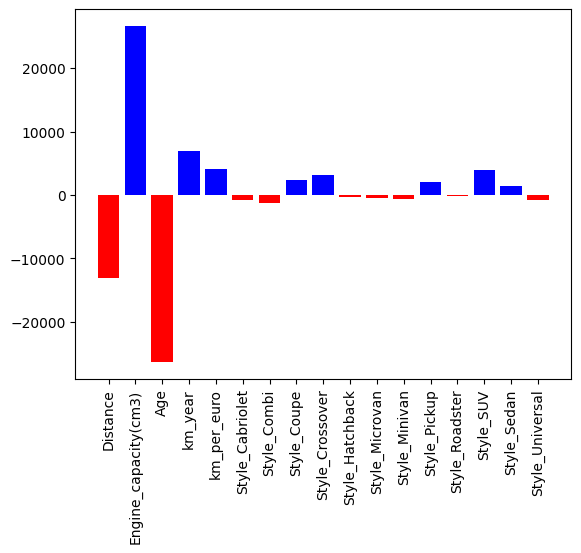

In [368]:
w, b = regr_linear.get_w_and_b()
vis_weigths(w, features_names)

В целом значения весов для параметров OHE не слишком высокие, однако использование данных признаков позволило несколько улучшить параметр R2.

## Выводы

Исходя из анализа весов моделей можем сделать следующие выводы:

* Чем больше пробег и/или возраст, тем цена ниже.
* Чем больше объем двигателя, тем цена выше.

На этом, пожалуй, всё.
До встречи в следующих эпизодах! =)
